In [36]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.16.1


In [37]:
import numpy as np

def calculate_miou(predictions, ground_truths):
    """
    Calcola la Mean Intersection over Union (MIoU) tra predizioni e verità terreno.
    
    Parameters:
        predictions (numpy.ndarray): Array delle predizioni, shape (64, 128, C).
        ground_truths (numpy.ndarray): Array delle verità terreno, shape (64, 128, C).
        
    Returns:
        float: MIoU calcolata sulle classi.
    """
    assert predictions.shape == ground_truths.shape, "Le shape devono coincidere!"
    C = predictions.shape[-1]
    
    iou_per_class = []
    
    for c in range(C):
        # Otteniamo la maschera per la classe c
        pred_class = predictions[..., c]
        gt_class = ground_truths[..., c]
        
        # Calcoliamo intersezione e unione
        intersection = np.logical_and(pred_class, gt_class).sum()
        union = np.logical_or(pred_class, gt_class).sum()
        
        # Evitiamo divisioni per zero
        if union == 0:
            iou = 1.0  # Se non ci sono pixel in questa classe, consideriamo IOU = 1
        else:
            iou = intersection / union
        
        iou_per_class.append(iou)
    
    # Calcoliamo la media delle IoU per tutte le classi
    print(iou_per_class)
    miou = np.mean(iou_per_class)
    return miou


In [38]:
!pip install tfa-nightly keras_cv Pillow

In [39]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

In [40]:
import numpy as np

data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

## Data cleaning

In [41]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


In [42]:

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Img 2 contains background


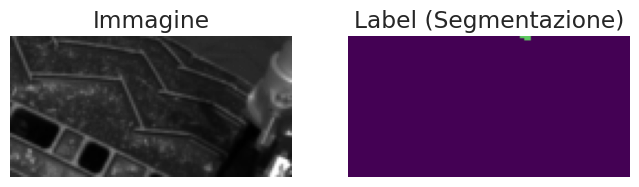

Img 3 contains background


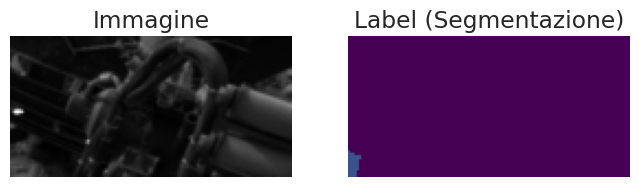

Img 4 contains background


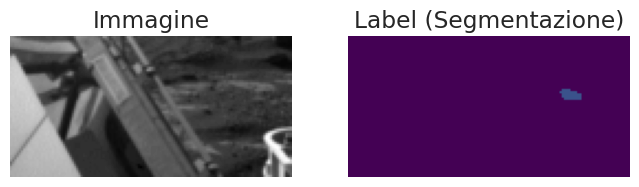

Img 7 contains background


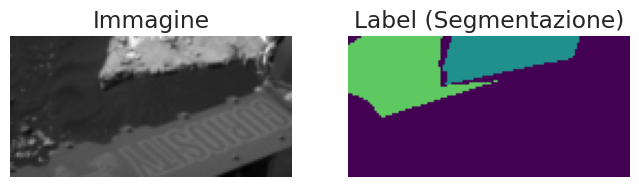

Img 8 contains background


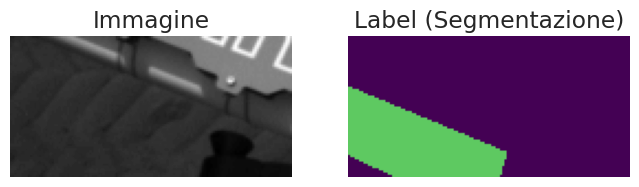

Img 10 contains background


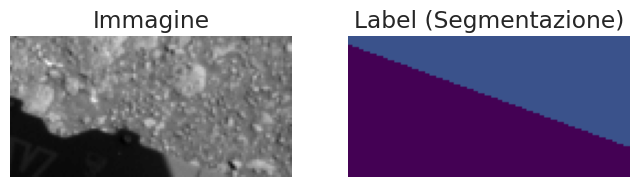

Img 11 contains background


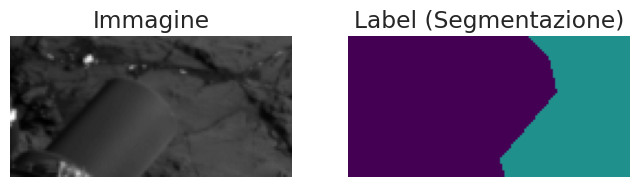

Img 12 contains background


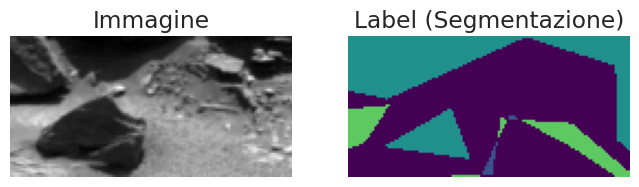

Img 15 contains background


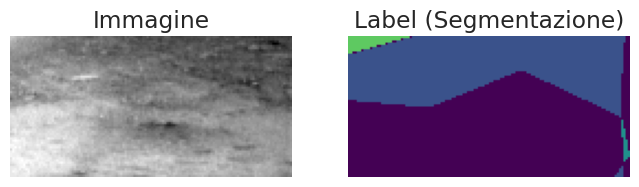

Img 23 contains background


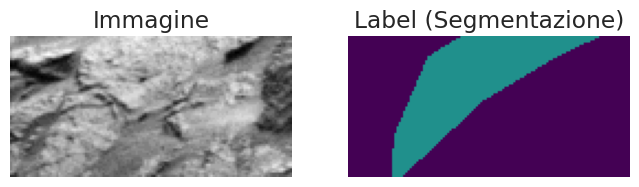

Img 26 contains background


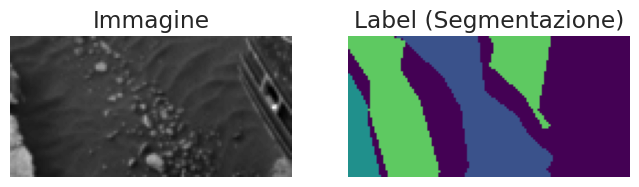

Img 30 contains background


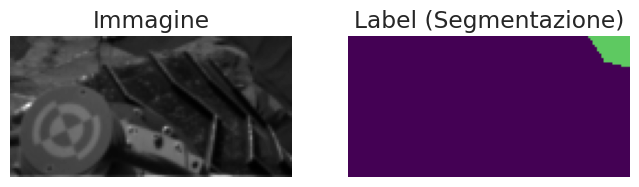

Img 32 contains background


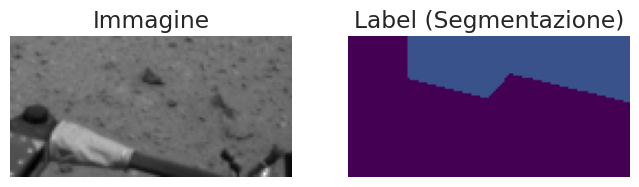

Img 35 contains background


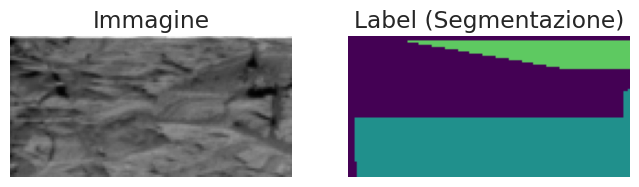

Img 42 contains background


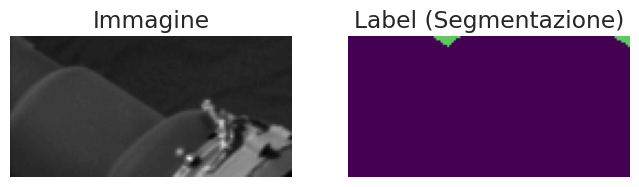

Img 46 contains background


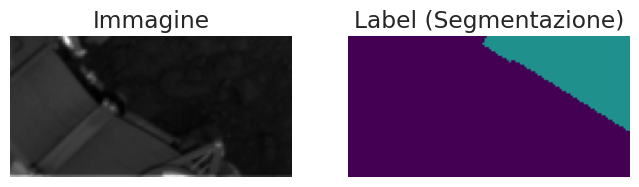

Img 49 contains background


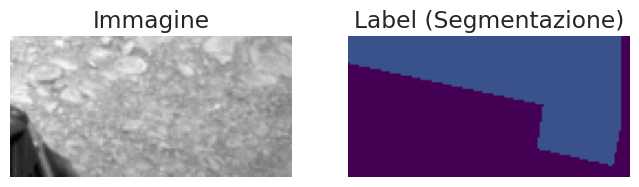

Img 52 contains background
Img 53 contains background
Img 55 contains background
Img 57 contains background
Img 58 contains background
Img 61 contains background
Img 67 contains background
Img 72 contains background
Img 76 contains background
Img 84 contains background
Img 89 contains background
Img 90 contains background
Img 100 contains background
Img 105 contains background
Img 106 contains background
Img 115 contains background
Img 116 contains background
Img 117 contains background
Img 120 contains background
Img 121 contains background
Img 130 contains background
Img 133 contains background
Img 134 contains background
Img 138 contains background
Img 140 contains background
Img 145 contains background
Img 149 contains background
Img 151 contains background
Img 154 contains background
Img 158 contains background
Img 161 contains background
Img 162 contains background
Img 164 contains background
Img 166 contains background
Img 170 contains background
Img 171 contains background
Img 

In [43]:
import numpy as np

# Parametri
label_value = 0  # Label di interesse
threshold_percentage = 40

# Itera su tutte le immagini e maschere
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == label_value):  # Check if class 4 is present in the label

        total_pixels = 64 * 128
        label_pixels = np.sum(lbl_batch == label_value)
        label_percentage = (label_pixels / total_pixels) * 100

        if label_percentage >= threshold_percentage:
            print(f"Img {i} contains background")

            if i < 50:
                # Plot original image
                plt.figure(figsize=(8, 4))
        
                plt.subplot(1, 2, 1)
                plt.imshow(img_batch, cmap='gray')
                plt.title("Immagine")
                plt.axis('off')
        
                # Apply the colormap to the segmentation labels
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))
        
                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(lbl_batch, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Label (Segmentazione)")
                plt.axis('off')
        
                plt.show()

In [44]:
def cleaning_background(label):
    
     # Conta il numero di pixel per ciascuna classe
    unique, counts = np.unique(label, return_counts=True)
    class_counts = dict(zip(unique, counts))
    
    # Rimuove la classe 0 dai conteggi per trovare la classe maggioritaria
    class_counts.pop(0, None)  # Ignora la classe 0
    if class_counts:
        # Trova la classe maggioritaria
        major_class = max(class_counts, key=class_counts.get)
    else:
        # Se l'unica classe presente è la 0, sostituisci con la classe 1
        major_class = 1

    major_class = 1

    # Sostituisci i pixel della classe 0 con la classe maggioritaria
    updated_label = np.where(label == 0, major_class, label)
    
    return updated_label
    

In [45]:
idx_background = [10, 11,12,15,23,26, 32,35,49,57,58,67,72,76,
                  84,90,105,106,115,116,133,140,145,149,158,162,164,166,170,182,191,194,
                  201,202,208,212,214,226,237,241,261,266,270,273,280,287,290,297,307,308,321,
                  325,326,339,342,364,368,382,385,386,388,397,399,406,414,423,427,428,
                  432,439,441,445,446,452,458,471,480,495,497,499,502,513,545,547,556,557,564,
                  560,591,601,602,605,614,626,632,654,655,660,674,683,685,692,693,698,
                  711,726,737,742,748,760,766,769,787,794,795,797,804,807,813,816,
                  824,833,843,848,850,851,867,868,872,873,874,881,882,887,888,915,918,920,
                  927,930,935,937,942,948,955,956,957,960,990,999,1022,1023,1026,1028,1030,1035,
                  1037,1040,1050,1060,1068,1079,1083,1085,1097,1099,1123,1141,1143,1156,1162,
                  1168,1173,1187,1193,1199,1200,1201,1204,1212,1219,1220,1225,1228,1231,
                  1233,1238,1246,1266,1282,1283,1311,1316,1318,1326,1332,1336,1344,1349,
                  1357,1372,1386,1403,1415,1426,1443,1456,1462,1464,1466,1469,1474,1491,1498,
                  1501,1508,1510,1514,1527,1534,1539,1540,1544,1548,1569,1572,1576,1585,
                  1587,1590,1593,1609,1617,1618,1627,1632,1646,1656,1681,1698,1702,1708,
                  1712,1751,1755,1756,1781,1786,1795,1808,1818,1824,1826,1832,1839,1841,
                  1853,1854,1866,1872,1900,1913,1917,1919,1942,1947,1952,1955,1960,1967,
                  1978,1982,1986,1990,1991,2000,2002,2003,2004,2014,2024,2029,2034,2048,
                  2050,2064,2065,2070,2071,2079,2087,2091,2106,2111,2115,2123,2124,2149,
                  2160,2163,2168,2171,2184,2185,2192,2193,2197,2199,2218,2225,2232,2234,
                  2246,2247,2253,2266,2287,2301,2308,2311,2313,2330,2331,2337,2354,2363,2365,
                  2369,2383,2399,2406,2409,2412,2414,2420,2432,2445,2451,2456,2473,2498]

print(len(idx_background))

341


In [46]:
'''import numpy as np

# Parametri
label_value = 0  # Label di interesse
threshold_percentage = 40

# Itera su tutte le immagini e maschere
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == label_value):  # Check if class 4 is present in the label

        total_pixels = 64 * 128
        label_pixels = np.sum(lbl_batch == label_value)
        label_percentage = (label_pixels / total_pixels) * 100

        if (label_percentage > 0.0) and ((label_percentage <= threshold_percentage) or i in idx_background):
            new_label = cleaning_background(lbl_batch)
            print(f"Img {i} contains background")

            if i < 50:
                # Apply the colormap to the segmentation labels
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))
                
                # Plot original image
                plt.figure(figsize=(8, 4))
        
                plt.subplot(1, 2, 1)
                colored_label = apply_colormap(lbl_batch, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Immagine")
                plt.axis('off')
        
        
                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(new_label, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Label (Segmentazione)")
                plt.axis('off')
        
                plt.show()
            
            y_train[i] = new_label'''

'import numpy as np\n\n# Parametri\nlabel_value = 0  # Label di interesse\nthreshold_percentage = 40\n\n# Itera su tutte le immagini e maschere\nfor i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):\n    # Check if any pixel in the label belongs to class 4\n    if np.any(lbl_batch == label_value):  # Check if class 4 is present in the label\n\n        total_pixels = 64 * 128\n        label_pixels = np.sum(lbl_batch == label_value)\n        label_percentage = (label_pixels / total_pixels) * 100\n\n        if (label_percentage > 0.0) and ((label_percentage <= threshold_percentage) or i in idx_background):\n            new_label = cleaning_background(lbl_batch)\n            print(f"Img {i} contains background")\n\n            if i < 50:\n                # Apply the colormap to the segmentation labels\n                colormap = plt.cm.viridis(np.linspace(0, 1, 5))\n                \n                # Plot original image\n                plt.figure(figsize=(8, 4))\n        \n 

In [47]:
'''idx_remove = [139,735,866,1174,1533,1780]

# Rimuovi gli indici da X_train e y_train
X_train = np.delete(X_train, idx_remove, axis=0)
y_train = np.delete(y_train, idx_remove, axis=0)'''

'idx_remove = [139,735,866,1174,1533,1780]\n\n# Rimuovi gli indici da X_train e y_train\nX_train = np.delete(X_train, idx_remove, axis=0)\ny_train = np.delete(y_train, idx_remove, axis=0)'

In [48]:
# Flatten y_train to aggregate pixel counts across all images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [49]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

In [50]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [51]:
# Input image
'''plt.subplot(1, 3, 1)

plt.imshow(X_train[1], cmap="gray")
plt.title("Input Image")
plt.axis('off')

# Ground truth
plt.subplot(1, 3, 2)
tensor_with_channel = tf.expand_dims(X_train[1], axis=-1)
img = augmentation_layer()(tensor_with_channel)
plt.imshow(img / 255.0, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()'''

'plt.subplot(1, 3, 1)\n\nplt.imshow(X_train[1], cmap="gray")\nplt.title("Input Image")\nplt.axis(\'off\')\n\n# Ground truth\nplt.subplot(1, 3, 2)\ntensor_with_channel = tf.expand_dims(X_train[1], axis=-1)\nimg = augmentation_layer()(tensor_with_channel)\nplt.imshow(img / 255.0, cmap="gray")\nplt.title("Ground Truth Mask")\nplt.axis(\'off\')\n\nplt.tight_layout()\nplt.show()\nplt.close()'

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
import keras_cv
import tensorflow as tf
from tensorflow.keras import layers, Model

def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.2),
        keras_cv.layers.RandomContrast([0, 255], 0.5),
        keras_cv.layers.RandomGaussianBlur(3, 2),
        tf.keras.layers.GaussianNoise(0.05)
    ])

def transformer_block(inputs, num_heads, ff_dim):
    """Transformer block for bottleneck or encoder/decoder layers."""
    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-Head Attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    # Skip Connection
    x = layers.Add()([attention_output, inputs])
    # Feed Forward Network
    ffn = tf.keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(inputs.shape[-1]),
    ])
    x_ffn = ffn(x)
    # Second Skip Connection
    x = layers.Add()([x_ffn, x])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def adaptive_fusion(feature_1, feature_2):
    """Adaptive feature fusion using trainable gates."""
    # Trainable gates for features
    gate_1 = layers.Dense(1, activation='sigmoid')(feature_1)
    gate_2 = layers.Dense(1, activation='sigmoid')(feature_2)
    # Weighted summation
    fused = gate_1 * feature_1 + gate_2 * feature_2
    return fused

def unet_with_transformer(input_shape=(64, 128, 1), num_classes=1):
    """U-Net with transformer bottleneck and adaptive fusion."""
    inputs = layers.Input(shape=input_shape)
    inputs = augmentation_layer()(inputs)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck with Transformer Block
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    bottleneck = transformer_block(bottleneck, num_heads=4, ff_dim=512)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    f1 = adaptive_fusion(c2, u1)  # Fusion of skip connection and upsampled features
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(f1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
    f2 = adaptive_fusion(c1, u2)  # Fusion of skip connection and upsampled features
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(f2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    # Output Layer
    output_layer = layers.Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation="softmax", name='output_layer')(c4)

    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='UNet_Model')

    return model


In [53]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}
    
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [54]:
import tensorflow_addons as tfa
import random

    
def rotate_fn(im, label):
    angolo = random.randint(-90, 90)

    # Otteniamo le dimensioni originali dell'immagine
    altezza, larghezza = im.shape[:2]
    
    # Calcoliamo il centro dell'immagine
    centro = (larghezza // 2, altezza // 2)
    
    # Calcoliamo la matrice di rotazione
    matrice_rotazione = cv2.getRotationMatrix2D(centro,angolo, 1.0)
    
    # Aggiustiamo la matrice per mantenere la stessa dimensione dell'immagine
    matrice_rotazione[0, 2] += (larghezza / 2) - centro[0]
    matrice_rotazione[1, 2] += (altezza / 2) - centro[1]
    
    # Ruotiamo l'immagine usando la matrice di rotazione
    immagine_ruotata = cv2.warpAffine(im, matrice_rotazione, (larghezza, altezza), flags=cv2.INTER_LINEAR)
    label_ruotata = cv2.warpAffine(label, matrice_rotazione, (larghezza, altezza), flags=cv2.INTER_LINEAR)

    return immagine_ruotata, label_ruotata



def translate_fn(im, label):
    # Genera spostamenti casuali lungo gli assi x e y
    shift_x = random.randint(-30, 30)
    shift_y = random.randint(-30, 30)

    # Otteniamo le dimensioni originali dell'immagine
    altezza, larghezza = im.shape[:2]

    # Creiamo la matrice di traslazione
    matrice_traslazione = np.array([
        [1, 0, shift_x],
        [0, 1, shift_y]
    ], dtype=np.float32)

    # Applichiamo la traslazione all'immagine e alla label
    immagine_traslata = cv2.warpAffine(im, matrice_traslazione, (larghezza, altezza), flags=cv2.INTER_LINEAR)
    label_traslata = cv2.warpAffine(label, matrice_traslazione, (larghezza, altezza), flags=cv2.INTER_NEAREST)

    return immagine_traslata, label_traslata

    
def zoom_fn(image, label):
    zoom_factor = tf.random.uniform([], 0.4, 1.6)


    # Get image dimensions (using tf.shape to avoid None)
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    new_height = tf.cast(tf.cast(height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * zoom_factor, tf.int32)

    # Resize the image and label to the new dimensions
    image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    label = tf.image.resize(label, [new_height, new_width], method='nearest')  # Nearest for labels

    # Crop or pad back to the original size
    image = tf.image.resize_with_crop_or_pad(image, height, width)
    label = tf.image.resize_with_crop_or_pad(label, height, width)

    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    label = tf.cast(label, tf.int32)

    return image, label

In [55]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""

    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    
    return image, label
    
@tf.function
def random_flip_up_down(image, label, seed=None):
    """Consistent random vertical flip."""

    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    
    return image, label
    
@tf.function
def random_zoom(image, label, seed=None):

    # Random Zoom (zoom in/out by the same factor)
    zoom_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        #zoom_prob > 0.5,
        zoom_prob >= 0.2,
        lambda: zoom_fn(image, label),
        lambda: (image, label)
    )

    return image, label
    
@tf.function
def random_rotate(image, label, seed=None):
    
    # Random Rotation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.2,
        lambda: rotate_fn(image, label),
        lambda: (image, label)
    )
    
    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    
    return image, label

@tf.function
def random_translation(image, label, seed=None):
    
    # Random translation
    rotation_prob = tf.random.uniform([], seed=seed)
    shift_x = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32, seed=seed)
    shift_y = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32, seed=seed)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.2,
        lambda: translate_fn(image, label, shift_x,shift_y),
        lambda: (image, label)
    )
    
    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    
    return image, label

In [56]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)
    
    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels
    
    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset2 = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset3 = dataset.map(
            lambda x, y: random_zoom(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset4 = dataset.map(
            lambda x, y: random_flip_up_down(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        '''
        dataset5 = dataset.map(
            lambda x, y: random_translation(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )'''
        
        dataset = dataset.concatenate(dataset2)
        dataset = dataset.concatenate(dataset3)
        dataset = dataset.concatenate(dataset4)

        
        # Print the shape of a single batch from the train_dataset
        '''for img_batch, lbl_batch in dataset.take(1):  # Taking the first batch
                plt.figure(figsize=(8, 4))
    
                print("Img " + str(i))
                
                # Immagine originale
                plt.subplot(1, 2, 1)
                plt.imshow(img_batch, cmap='gray' if len(img.shape) == 2 else None)
                plt.title("Immagine")
                plt.axis('off')
                
                # Label di segmentazione
        
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))


                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(tf.math.argmax(lbl_batch, axis=-1), colormap)

                plt.imshow(colored_label, cmap='gray' if len(label.shape) == 2 else None)
                plt.title("Label (Segmentazione)")
                plt.axis('off')
                
                plt.show()'''



    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [57]:
import cv2

num_samples = len(X_train)
new_X_train = np.empty((2 * num_samples, *X_train.shape[1:]), dtype=X_train.dtype)
new_y_train = np.empty((2 * num_samples, *y_train.shape[1:]), dtype=y_train.dtype)

# Copia i dati originali
new_X_train[:num_samples] = X_train
new_y_train[:num_samples] = y_train

# Applica l'augmentazione direttamente sugli array preallocati
for idx in range(num_samples):
    img, label = rotate_fn(np.copy(X_train[idx]), np.copy(y_train[idx]))
    new_X_train[num_samples + idx] = img
    new_y_train[num_samples + idx] = label

X_train = new_X_train
y_train = new_y_train

num_samples = len(X_train)
new_X_train = np.empty((2 * num_samples, *X_train.shape[1:]), dtype=X_train.dtype)
new_y_train = np.empty((2 * num_samples, *y_train.shape[1:]), dtype=y_train.dtype)

# Copia i dati originali
new_X_train[:num_samples] = X_train
new_y_train[:num_samples] = y_train

# Applica l'augmentazione direttamente sugli array preallocati
for idx in range(num_samples):
    img, label = translate_fn(np.copy(X_train[idx]), np.copy(y_train[idx]))
    new_X_train[num_samples + idx] = img
    new_y_train[num_samples + idx] = label

X_train = new_X_train
y_train = new_y_train

In [58]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=False,
    seed=seed
)

In [59]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)


Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [60]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    #model = get_unet_model()
    #model = unet_with_complex_bottleneck()
    model = unet_with_transformer()
    #model = build_multi_res_unet((64,128,1), NUM_CLASSES)

In [61]:
import random

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)
    
        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
    
        # Apply the colormap
        colored = colormap[label.astype(int)]
    
        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [62]:
import tensorflow as tf
import tensorflow.keras.backend as K

import tensorflow as tf
import numpy as np

total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}
#class_weights = {0:1,1:0,2:0,3:0,4:1}
# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
#class_weights_tensor /= tf.norm(class_weights_tensor)

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Ensure y_pred is normalized (softmax)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class weights
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    weighted_cross_entropy = weights * cross_entropy
    return tf.reduce_mean(weighted_cross_entropy)

def boundary_loss(y_true, y_pred):
    # Assume y_true and y_pred have shape (n, 64, 128, 5)

    # Compute boundaries (edge detection) for y_true and y_pred
    y_true_boundary = tf.image.extract_patches(
        y_true, sizes=[1, 3, 3, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='SAME')
    y_pred_boundary = tf.image.extract_patches(
        y_pred, sizes=[1, 3, 3, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='SAME')

    # Compute the boundary loss (difference between true and predicted boundaries)
    boundary_loss = tf.reduce_mean(tf.abs(y_true_boundary - y_pred_boundary))

    return boundary_loss
    

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
    
    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)
    
    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy
    
    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    
def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(dice)
    
def weighted_dice_loss(y_true, y_pred, class_weights):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Apply softmax to predictions if necessary
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    
    # Smooth factor to avoid division by zero
    smooth = 1e-6
    
    # Compute Dice numerator and denominator for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Sum over spatial dimensions
    union = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2])
    
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    
    # Compute weighted Dice loss
    class_weights = tf.convert_to_tensor(class_weights, dtype=tf.float32)
    weighted_dice = class_weights * (1.0 - dice_score)  # Higher weights for more important classes
    
    # Reduce to a single scalar loss value
    loss = tf.reduce_mean(weighted_dice)
    return loss
    
def iou_loss_for_class(y_true, y_pred, target_class, smooth=1e-6):
    """
    IoU loss for a specific class.

    Args:
    - y_true: Ground truth labels, one-hot encoded.
    - y_pred: Predicted logits or probabilities, same shape as y_true.
    - target_class: Index of the target class to calculate IoU for.
    - smooth: Small value to avoid division by zero.

    Returns:
    - IoU loss for the target class.
    """
    # Extract the class-specific predictions and ground truth
    y_true_class = y_true[..., target_class]
    y_pred_class = y_pred[..., target_class]

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true_class * y_pred_class)
    union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)

    # IoU loss is 1 - IoU
    return 1 - iou
    
@tf.function
def combined_loss(y_true, y_pred, lambda_=0.5):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_dice = weighted_dice_loss(y_true, y_pred, class_weights_tensor)
    loss_focal = focal_loss(y_true, y_pred)
 
    return loss_ce + loss_dice + loss_focal

# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
            tf.keras.metrics.IoU(NUM_CLASSES, [1], name="class1", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [2], name="class2", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [3], name="class3", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [4], name="class4", sparse_y_true=False, sparse_y_pred=False)
        ]
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [63]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',
        mode='max',
        patience=30,
        restore_best_weights=True
    )
    
    viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class1: 0.1106 - class2: 0.0645 - class3: 0.0316 - class4: 9.8832e-04 - loss: 175.9025 - mean_iou: 0.0457

W0000 00:00:1734164290.540941      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

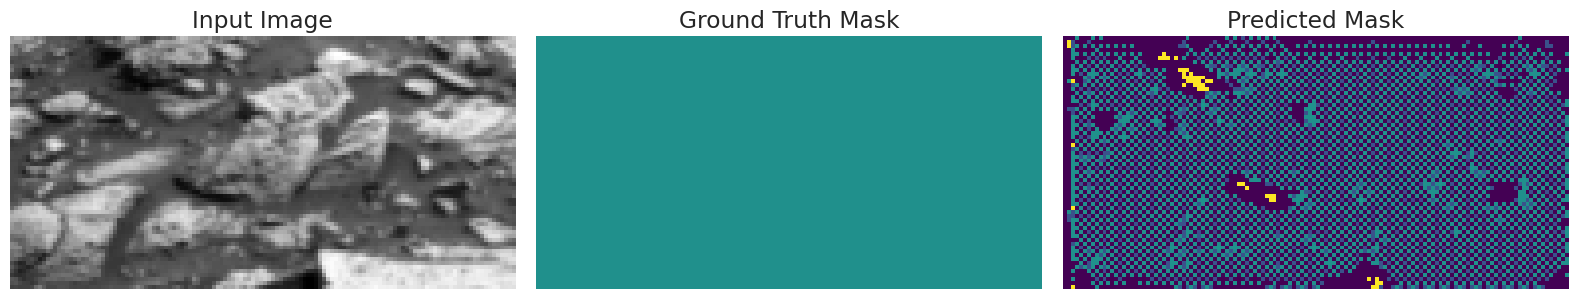

126/126 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - class1: 0.1099 - class2: 0.0644 - class3: 0.0314 - class4: 9.9095e-04 - loss: 175.8810 - mean_iou: 0.0454 - val_class1: 0.0838 - val_class2: 0.1671 - val_class3: 0.0000e+00 - val_class4: 0.0018 - val_loss: 162.5466 - val_mean_iou: 0.0572
Epoch 2/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.2285 - class2: 0.1285 - class3: 0.0931 - class4: 0.0032 - loss: 174.6111 - mean_iou: 0.1026 - val_class1: 0.2917 - val_class2: 0.0601 - val_class3: 0.1641 - val_class4: 0.0012 - val_loss: 161.8978 - val_mean_iou: 0.1187
Epoch 3/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.2529 - class2: 0.1190 - class3: 0.2452 - class4: 0.0042 - loss: 174.6280 - mean_iou: 0.1435 - val_class1: 0.3368 - val_class2: 0.0120 - val_class3: 0.1669 - val_class4: 0.0084 - val_loss: 161.6845 - val_mean_iou: 0.1205
Epoch 4/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.2470 - class2: 0.1610 - class3: 0.3098 - class4: 0.0048 - loss: 174.1185 - me

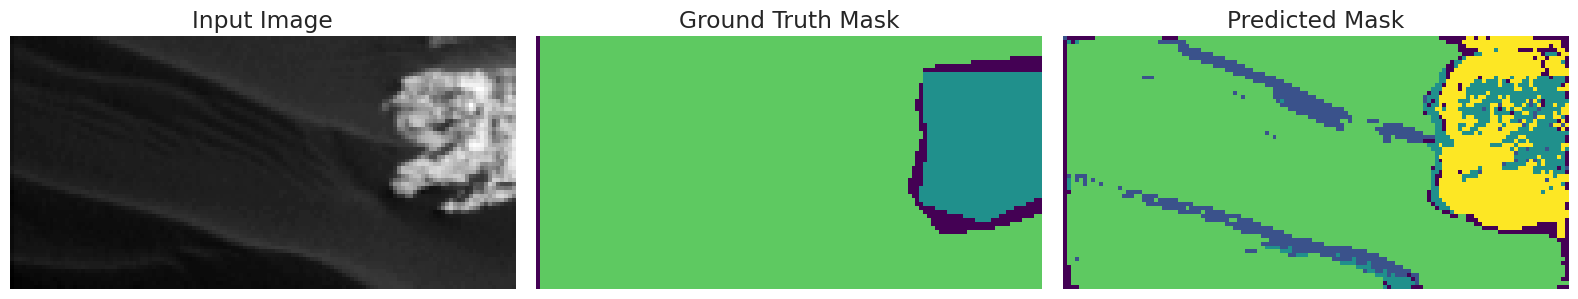

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.3012 - class2: 0.2294 - class3: 0.4327 - class4: 0.0052 - loss: 173.5298 - mean_iou: 0.2248 - val_class1: 0.2706 - val_class2: 0.2422 - val_class3: 0.4477 - val_class4: 0.0073 - val_loss: 160.5677 - val_mean_iou: 0.2275
Epoch 7/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.3397 - class2: 0.2312 - class3: 0.4400 - class4: 0.0060 - loss: 173.5319 - mean_iou: 0.2364 - val_class1: 0.3381 - val_class2: 0.2330 - val_class3: 0.4796 - val_class4: 0.0066 - val_loss: 160.5522 - val_mean_iou: 0.2444
Epoch 8/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.3840 - class2: 0.2535 - class3: 0.4778 - class4: 0.0064 - loss: 172.9974 - mean_iou: 0.2588 - val_class1: 0.4204 - val_class2: 0.2496 - val_class3: 0.4790 - val_class4: 0.0021 - val_loss: 160.5323 - val_mean_iou: 0.2620
Epoch 9/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.3637 - class2: 0.2369 - class3: 0.4537 - class4: 0.0065 - loss: 172.6275 - mean_iou: 

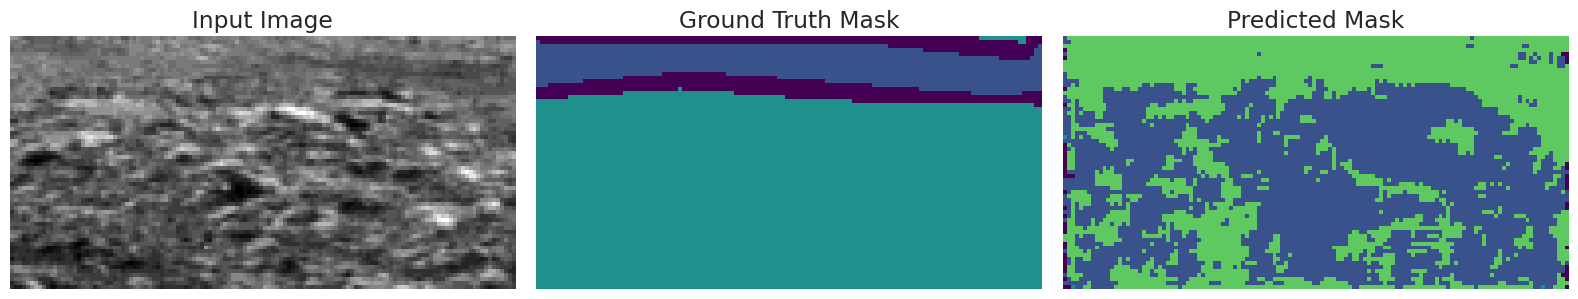

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.4057 - class2: 0.2903 - class3: 0.4805 - class4: 0.0082 - loss: 172.8475 - mean_iou: 0.2737 - val_class1: 0.4226 - val_class2: 0.2913 - val_class3: 0.4915 - val_class4: 0.0118 - val_loss: 159.9436 - val_mean_iou: 0.2674
Epoch 12/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.4295 - class2: 0.3271 - class3: 0.4956 - class4: 0.0097 - loss: 172.3387 - mean_iou: 0.2916 - val_class1: 0.3496 - val_class2: 0.3087 - val_class3: 0.4984 - val_class4: 0.0018 - val_loss: 160.0077 - val_mean_iou: 0.2654
Epoch 13/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.4781 - class2: 0.3723 - class3: 0.5258 - class4: 0.0105 - loss: 172.1228 - mean_iou: 0.3209 - val_class1: 0.4758 - val_class2: 0.3525 - val_class3: 0.5437 - val_class4: 0.0227 - val_loss: 158.7627 - val_mean_iou: 0.3304
Epoch 14/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.5065 - class2: 0.3887 - class3: 0.5285 - class4: 0.0122 - loss: 171.9850 - mean_io

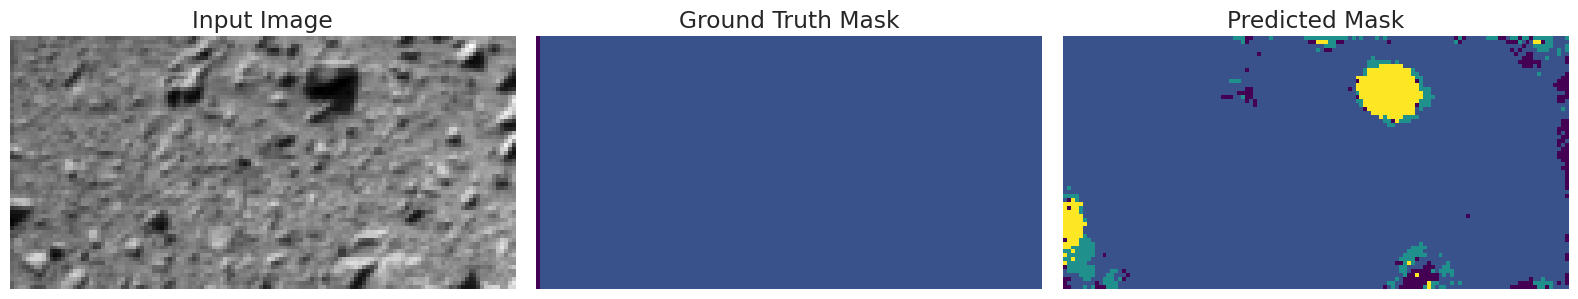

126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.5674 - class2: 0.4514 - class3: 0.5522 - class4: 0.0161 - loss: 171.7167 - mean_iou: 0.3696 - val_class1: 0.6397 - val_class2: 0.3697 - val_class3: 0.5379 - val_class4: 0.0117 - val_loss: 158.5332 - val_mean_iou: 0.3635
Epoch 17/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.5938 - class2: 0.4717 - class3: 0.5797 - class4: 0.0174 - loss: 171.3204 - mean_iou: 0.3875 - val_class1: 0.6597 - val_class2: 0.4874 - val_class3: 0.5390 - val_class4: 0.0027 - val_loss: 158.7681 - val_mean_iou: 0.3861
Epoch 18/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.6075 - class2: 0.4935 - class3: 0.5789 - class4: 0.0209 - loss: 170.9585 - mean_iou: 0.3977 - val_class1: 0.6187 - val_class2: 0.4493 - val_class3: 0.5127 - val_class4: 0.0106 - val_loss: 158.9037 - val_mean_iou: 0.3671
Epoch 19/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.6069 - class2: 0.4898 - class3: 0.5701 - class4: 0.0204 - loss: 171.4876 - mean_io

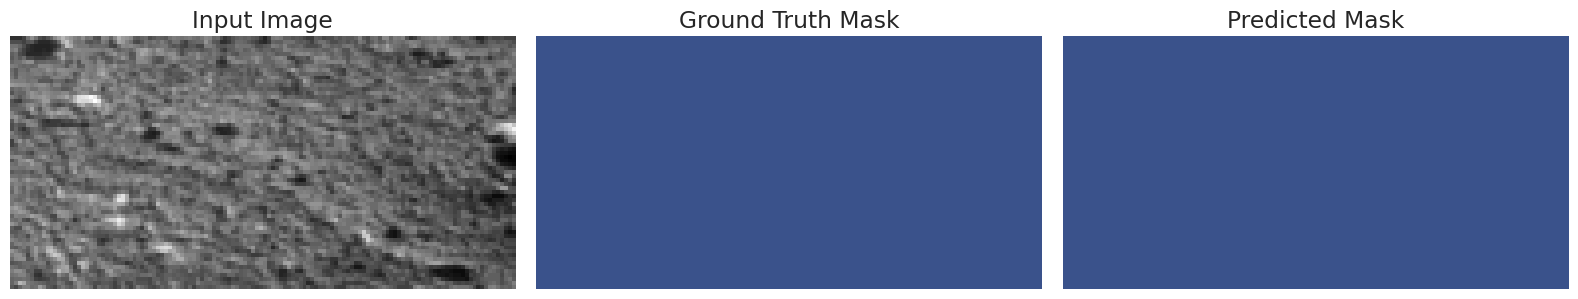

126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.6388 - class2: 0.5205 - class3: 0.5956 - class4: 0.0272 - loss: 170.8910 - mean_iou: 0.4194 - val_class1: 0.6779 - val_class2: 0.4819 - val_class3: 0.5843 - val_class4: 0.0183 - val_loss: 157.9050 - val_mean_iou: 0.4085
Epoch 22/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6285 - class2: 0.5223 - class3: 0.5935 - class4: 0.0285 - loss: 171.0717 - mean_iou: 0.4143 - val_class1: 0.6588 - val_class2: 0.4981 - val_class3: 0.5732 - val_class4: 0.0356 - val_loss: 158.2858 - val_mean_iou: 0.4358
Epoch 23/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6416 - class2: 0.5284 - class3: 0.6055 - class4: 0.0314 - loss: 170.9996 - mean_iou: 0.4247 - val_class1: 0.6631 - val_class2: 0.4970 - val_class3: 0.6025 - val_class4: 0.0773 - val_loss: 157.7514 - val_mean_iou: 0.4483
Epoch 24/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.6430 - class2: 0.5428 - class3: 0.5978 - class4: 0.0373 - loss: 170.5461 - mean_io

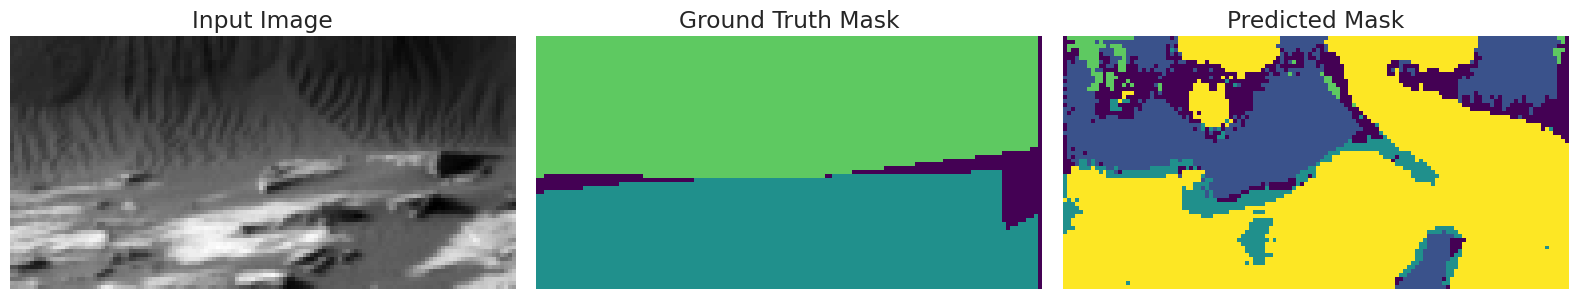

126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.6531 - class2: 0.5471 - class3: 0.6095 - class4: 0.0315 - loss: 171.0069 - mean_iou: 0.4317 - val_class1: 0.6252 - val_class2: 0.4894 - val_class3: 0.5960 - val_class4: 0.0217 - val_loss: 157.7192 - val_mean_iou: 0.4010
Epoch 27/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.6559 - class2: 0.5480 - class3: 0.6150 - class4: 0.0301 - loss: 170.9048 - mean_iou: 0.4324 - val_class1: 0.7075 - val_class2: 0.5346 - val_class3: 0.7085 - val_class4: 0.0494 - val_loss: 157.2526 - val_mean_iou: 0.4709
Epoch 28/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.6740 - class2: 0.5706 - class3: 0.6330 - class4: 0.0458 - loss: 170.5150 - mean_iou: 0.4526 - val_class1: 0.6838 - val_class2: 0.5712 - val_class3: 0.5696 - val_class4: 0.0240 - val_loss: 158.2110 - val_mean_iou: 0.4245
Epoch 29/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6773 - class2: 0.5747 - class3: 0.6292 - class4: 0.0444 - loss: 170.8515 - mean_io

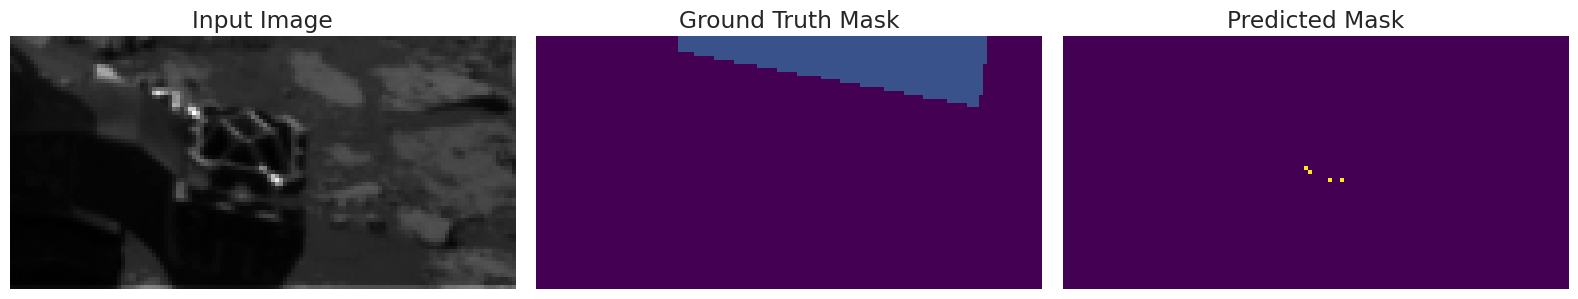

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6867 - class2: 0.5889 - class3: 0.6404 - class4: 0.0560 - loss: 170.3777 - mean_iou: 0.4656 - val_class1: 0.7179 - val_class2: 0.5049 - val_class3: 0.6307 - val_class4: 0.0712 - val_loss: 157.6680 - val_mean_iou: 0.4516
Epoch 32/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.6727 - class2: 0.5751 - class3: 0.6349 - class4: 0.0440 - loss: 170.7959 - mean_iou: 0.4532 - val_class1: 0.7066 - val_class2: 0.5833 - val_class3: 0.7236 - val_class4: 0.0024 - val_loss: 157.9089 - val_mean_iou: 0.4627
Epoch 33/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.6851 - class2: 0.5930 - class3: 0.6455 - class4: 0.0594 - loss: 170.4267 - mean_iou: 0.4689 - val_class1: 0.7063 - val_class2: 0.5377 - val_class3: 0.6330 - val_class4: 0.0089 - val_loss: 157.9418 - val_mean_iou: 0.4429
Epoch 34/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6801 - class2: 0.5834 - class3: 0.6261 - class4: 0.0433 - loss: 170.4724 - mean_io

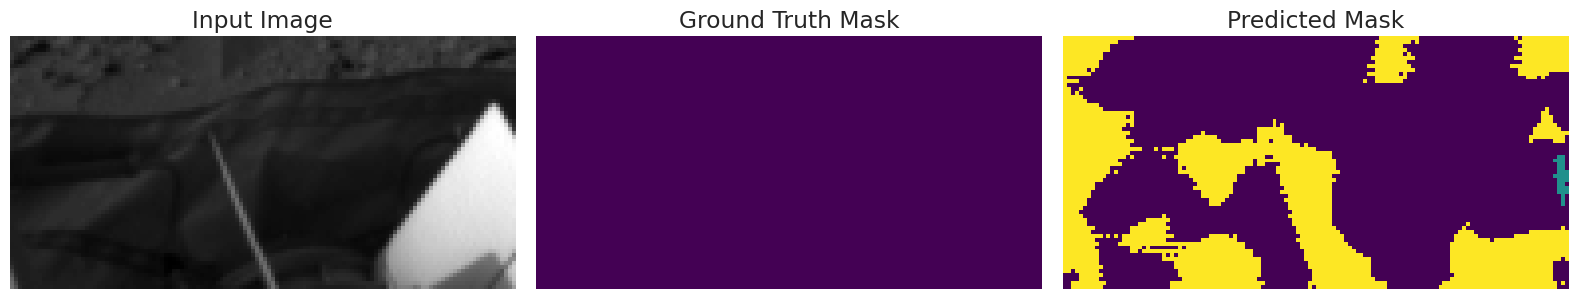

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6949 - class2: 0.6049 - class3: 0.6543 - class4: 0.0492 - loss: 169.8553 - mean_iou: 0.4686 - val_class1: 0.7094 - val_class2: 0.5914 - val_class3: 0.5612 - val_class4: 0.0854 - val_loss: 158.2151 - val_mean_iou: 0.4479
Epoch 37/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.6968 - class2: 0.6049 - class3: 0.6633 - class4: 0.0644 - loss: 170.4062 - mean_iou: 0.4783 - val_class1: 0.6931 - val_class2: 0.6015 - val_class3: 0.6865 - val_class4: 0.1866 - val_loss: 157.8797 - val_mean_iou: 0.5268
Epoch 38/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.6959 - class2: 0.6110 - class3: 0.6633 - class4: 0.0689 - loss: 170.2915 - mean_iou: 0.4834 - val_class1: 0.6728 - val_class2: 0.5971 - val_class3: 0.6727 - val_class4: 0.0717 - val_loss: 157.7499 - val_mean_iou: 0.5104
Epoch 39/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7067 - class2: 0.6183 - class3: 0.6740 - class4: 0.0749 - loss: 170.0091 - mean_io

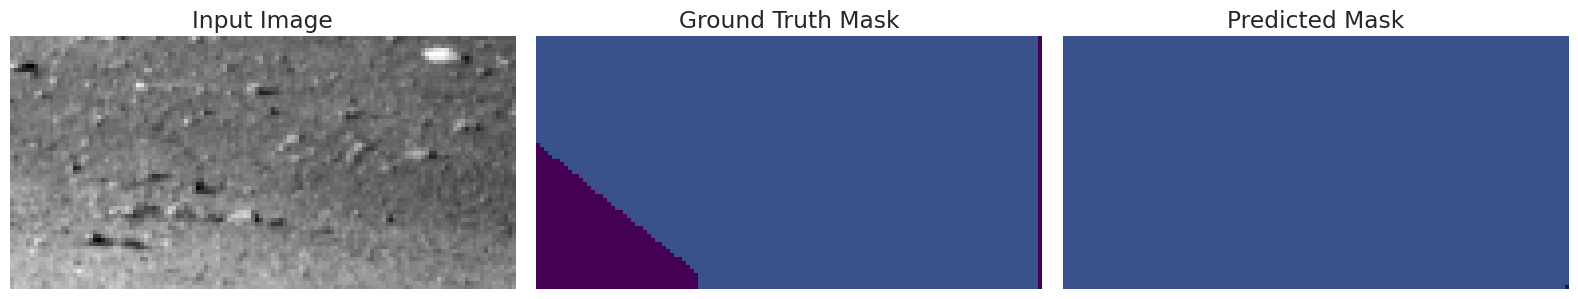

126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.7084 - class2: 0.6161 - class3: 0.6780 - class4: 0.0611 - loss: 170.0237 - mean_iou: 0.4878 - val_class1: 0.6729 - val_class2: 0.5841 - val_class3: 0.5953 - val_class4: 0.0864 - val_loss: 157.9994 - val_mean_iou: 0.4796
Epoch 42/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7160 - class2: 0.6293 - class3: 0.6795 - class4: 0.0786 - loss: 170.2319 - mean_iou: 0.4999 - val_class1: 0.7708 - val_class2: 0.5963 - val_class3: 0.6715 - val_class4: 0.0663 - val_loss: 157.3571 - val_mean_iou: 0.4984
Epoch 43/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.7066 - class2: 0.6272 - class3: 0.6718 - class4: 0.0627 - loss: 170.3250 - mean_iou: 0.4876 - val_class1: 0.6769 - val_class2: 0.5478 - val_class3: 0.6027 - val_class4: 0.0000e+00 - val_loss: 158.2943 - val_mean_iou: 0.4141
Epoch 44/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7121 - class2: 0.6237 - class3: 0.6802 - class4: 0.0598 - loss: 170.0903 - mea

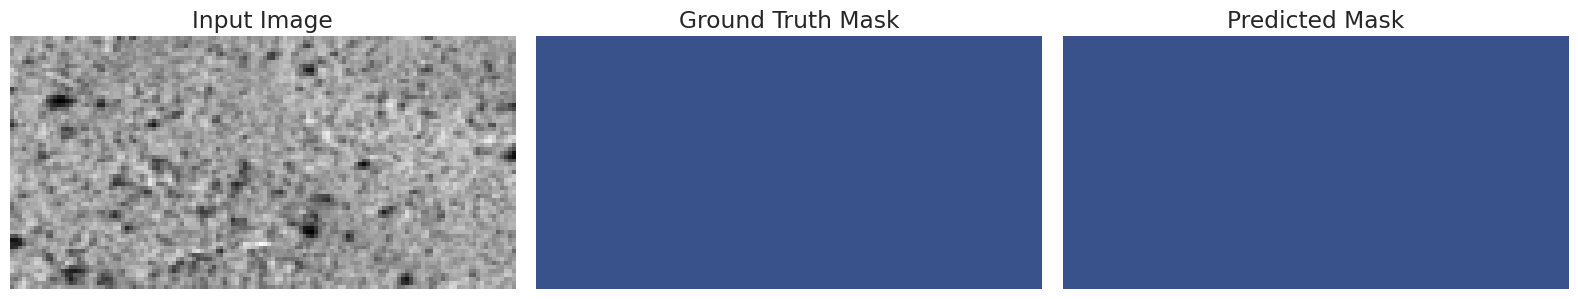

126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7031 - class2: 0.6088 - class3: 0.6818 - class4: 0.0512 - loss: 170.3051 - mean_iou: 0.4825 - val_class1: 0.6768 - val_class2: 0.5587 - val_class3: 0.6814 - val_class4: 0.1251 - val_loss: 157.9936 - val_mean_iou: 0.4894
Epoch 47/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7229 - class2: 0.6349 - class3: 0.6993 - class4: 0.0728 - loss: 169.7957 - mean_iou: 0.5063 - val_class1: 0.6914 - val_class2: 0.5371 - val_class3: 0.6891 - val_class4: 0.0121 - val_loss: 158.2966 - val_mean_iou: 0.4527
Epoch 48/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.7224 - class2: 0.6318 - class3: 0.7022 - class4: 0.0775 - loss: 169.8245 - mean_iou: 0.5064 - val_class1: 0.7320 - val_class2: 0.5715 - val_class3: 0.6751 - val_class4: 0.0682 - val_loss: 158.2987 - val_mean_iou: 0.4887
Epoch 49/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7322 - class2: 0.6469 - class3: 0.7151 - class4: 0.0918 - loss: 169.9964 - mean_io

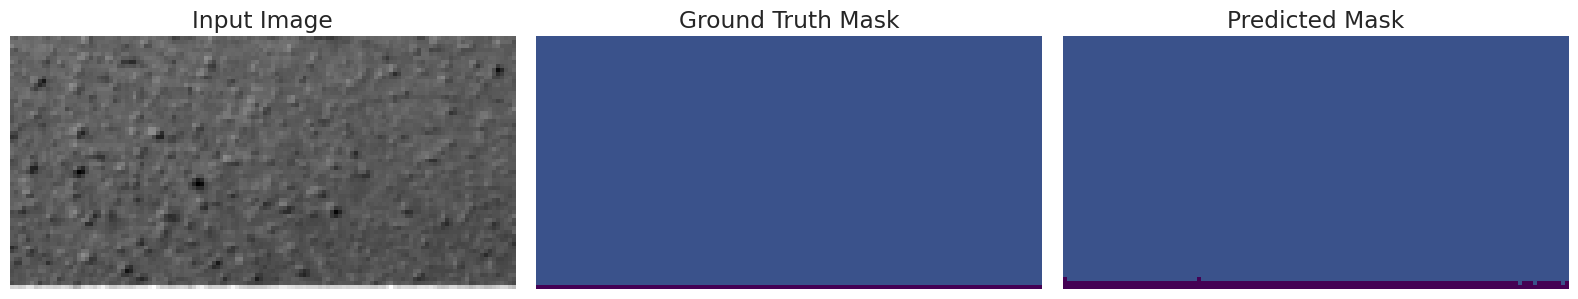

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7094 - class2: 0.6164 - class3: 0.6710 - class4: 0.0520 - loss: 170.2726 - mean_iou: 0.4796 - val_class1: 0.6433 - val_class2: 0.4965 - val_class3: 0.6543 - val_class4: 0.0041 - val_loss: 158.5739 - val_mean_iou: 0.4162
Epoch 52/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7193 - class2: 0.6347 - class3: 0.7009 - class4: 0.0745 - loss: 170.1844 - mean_iou: 0.5018 - val_class1: 0.7124 - val_class2: 0.5732 - val_class3: 0.6407 - val_class4: 0.2000 - val_loss: 157.3437 - val_mean_iou: 0.5171
Epoch 53/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7317 - class2: 0.6481 - class3: 0.7204 - class4: 0.0953 - loss: 169.8399 - mean_iou: 0.5214 - val_class1: 0.6794 - val_class2: 0.5404 - val_class3: 0.6980 - val_class4: 0.1023 - val_loss: 157.5445 - val_mean_iou: 0.4883
Epoch 54/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7398 - class2: 0.6654 - class3: 0.7290 - class4: 0.0989 - loss: 169.6585 - mean_io

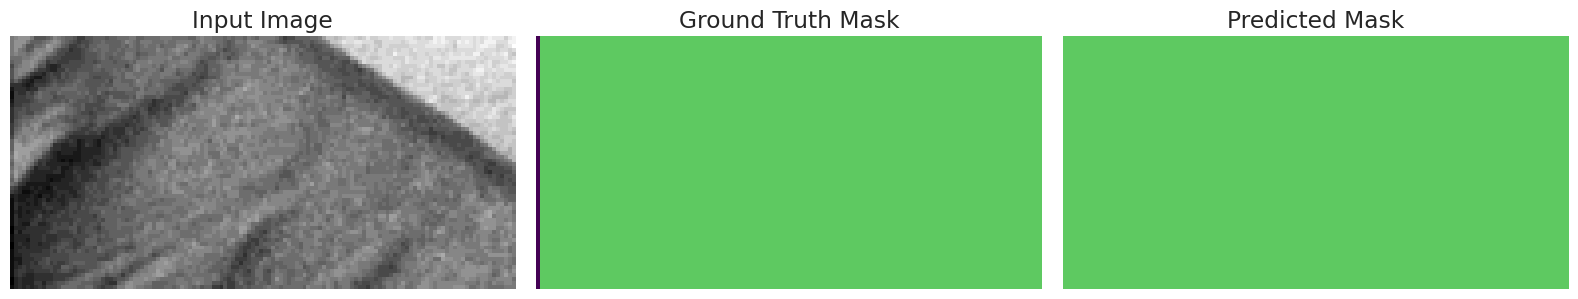

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7446 - class2: 0.6609 - class3: 0.7326 - class4: 0.0913 - loss: 169.6120 - mean_iou: 0.5297 - val_class1: 0.7279 - val_class2: 0.5706 - val_class3: 0.6969 - val_class4: 0.0196 - val_loss: 157.8792 - val_mean_iou: 0.4861
Epoch 57/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.7379 - class2: 0.6592 - class3: 0.7325 - class4: 0.0921 - loss: 169.7783 - mean_iou: 0.5272 - val_class1: 0.7133 - val_class2: 0.4493 - val_class3: 0.6551 - val_class4: 0.0153 - val_loss: 157.5375 - val_mean_iou: 0.4274
Epoch 58/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7425 - class2: 0.6667 - class3: 0.7381 - class4: 0.0855 - loss: 169.7133 - mean_iou: 0.5274 - val_class1: 0.6915 - val_class2: 0.5590 - val_class3: 0.7085 - val_class4: 0.2011 - val_loss: 158.0004 - val_mean_iou: 0.5232
Epoch 59/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7488 - class2: 0.6787 - class3: 0.7398 - class4: 0.0941 - loss: 169.3858 - mean_io

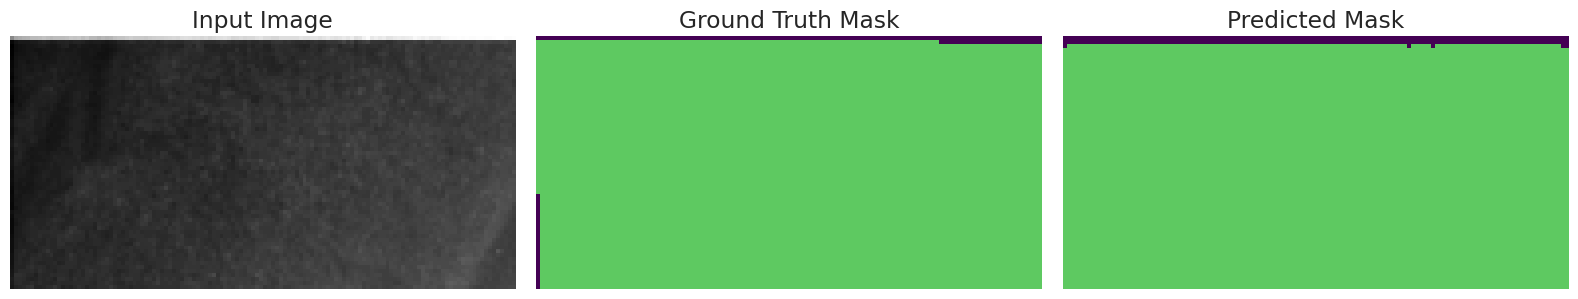

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7581 - class2: 0.6883 - class3: 0.7495 - class4: 0.1085 - loss: 169.4323 - mean_iou: 0.5481 - val_class1: 0.7717 - val_class2: 0.6102 - val_class3: 0.7403 - val_class4: 0.1028 - val_loss: 156.8473 - val_mean_iou: 0.5391
Epoch 62/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7544 - class2: 0.6874 - class3: 0.7444 - class4: 0.0890 - loss: 169.4769 - mean_iou: 0.5380 - val_class1: 0.7034 - val_class2: 0.5369 - val_class3: 0.6776 - val_class4: 0.1642 - val_loss: 156.7919 - val_mean_iou: 0.4907
Epoch 63/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7611 - class2: 0.6910 - class3: 0.7569 - class4: 0.1075 - loss: 169.6506 - mean_iou: 0.5491 - val_class1: 0.7201 - val_class2: 0.5500 - val_class3: 0.6555 - val_class4: 0.1980 - val_loss: 157.4481 - val_mean_iou: 0.5040
Epoch 64/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7644 - class2: 0.7048 - class3: 0.7697 - class4: 0.1314 - loss: 169.1658 - mean_io

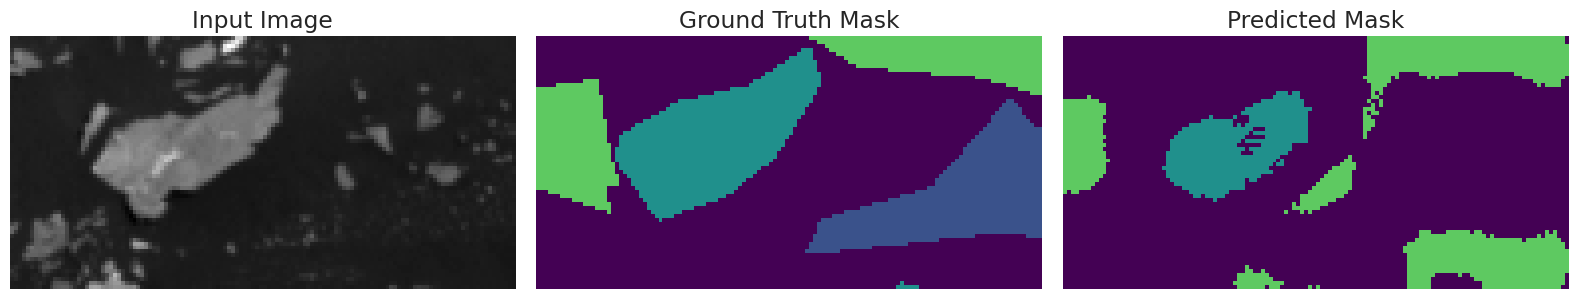

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7674 - class2: 0.7030 - class3: 0.7674 - class4: 0.1102 - loss: 169.2314 - mean_iou: 0.5563 - val_class1: 0.7223 - val_class2: 0.5430 - val_class3: 0.6454 - val_class4: 0.1557 - val_loss: 157.0842 - val_mean_iou: 0.5052
Epoch 67/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7755 - class2: 0.7138 - class3: 0.7722 - class4: 0.1419 - loss: 169.2772 - mean_iou: 0.5773 - val_class1: 0.6462 - val_class2: 0.5277 - val_class3: 0.6182 - val_class4: 0.0646 - val_loss: 161.1023 - val_mean_iou: 0.4326
Epoch 68/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7808 - class2: 0.7216 - class3: 0.7789 - class4: 0.1476 - loss: 169.5690 - mean_iou: 0.5839 - val_class1: 0.6607 - val_class2: 0.4633 - val_class3: 0.6420 - val_class4: 0.1699 - val_loss: 160.1868 - val_mean_iou: 0.4456
Epoch 69/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7818 - class2: 0.7215 - class3: 0.7828 - class4: 0.1432 - loss: 169.3407 - mean_io

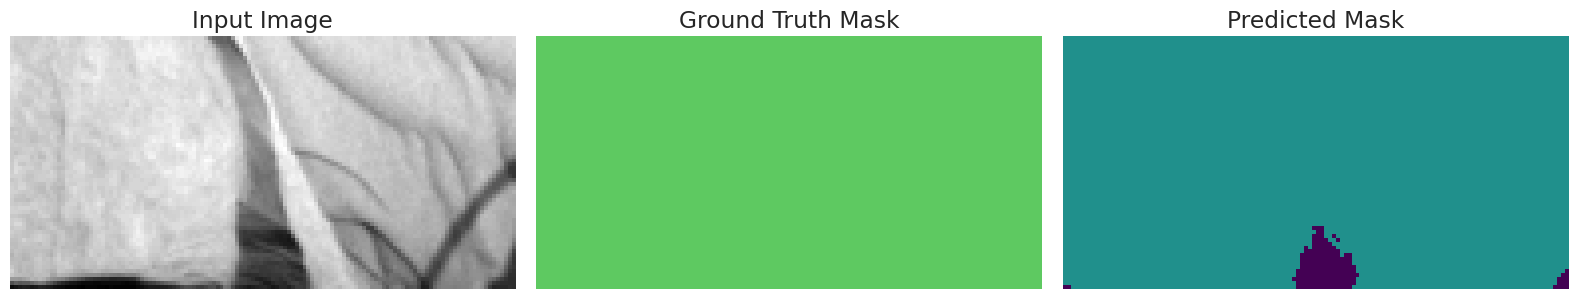

126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.7812 - class2: 0.7303 - class3: 0.7801 - class4: 0.1504 - loss: 169.3620 - mean_iou: 0.5847 - val_class1: 0.7228 - val_class2: 0.5691 - val_class3: 0.7184 - val_class4: 0.1845 - val_loss: 157.7967 - val_mean_iou: 0.5262
Epoch 72/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.7813 - class2: 0.7272 - class3: 0.7831 - class4: 0.1274 - loss: 169.0168 - mean_iou: 0.5712 - val_class1: 0.7190 - val_class2: 0.5270 - val_class3: 0.7038 - val_class4: 0.2077 - val_loss: 159.0871 - val_mean_iou: 0.5181
Epoch 73/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.7840 - class2: 0.7296 - class3: 0.7864 - class4: 0.1353 - loss: 169.3052 - mean_iou: 0.5800 - val_class1: 0.7052 - val_class2: 0.5993 - val_class3: 0.6558 - val_class4: 0.0917 - val_loss: 161.9516 - val_mean_iou: 0.4800
Epoch 74/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.7908 - class2: 0.7346 - class3: 0.7892 - class4: 0.1356 - loss: 168.8983 - mean_io

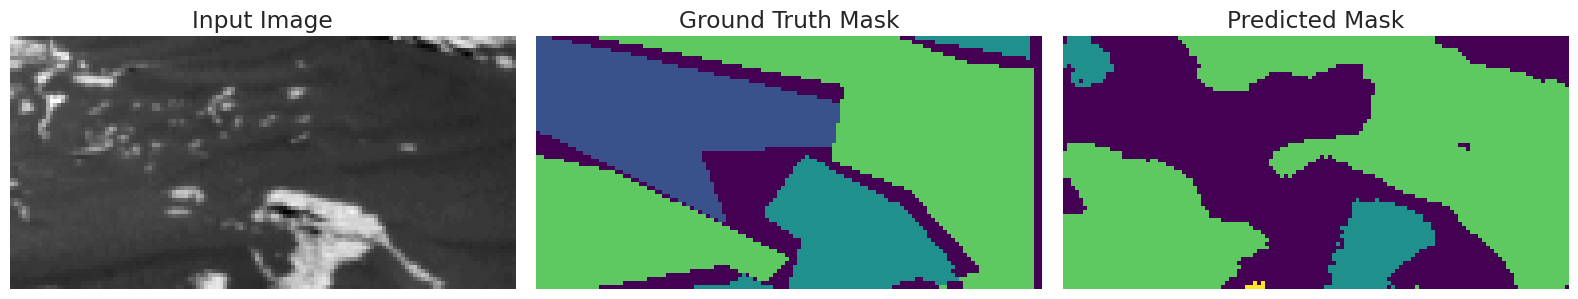

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7927 - class2: 0.7329 - class3: 0.7919 - class4: 0.1313 - loss: 169.1936 - mean_iou: 0.5805 - val_class1: 0.7377 - val_class2: 0.6125 - val_class3: 0.7452 - val_class4: 0.0109 - val_loss: 157.9762 - val_mean_iou: 0.4792
Epoch 82/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8034 - class2: 0.7385 - class3: 0.7968 - class4: 0.1346 - loss: 169.0429 - mean_iou: 0.5845 - val_class1: 0.7428 - val_class2: 0.6049 - val_class3: 0.7496 - val_class4: 0.1187 - val_loss: 158.4531 - val_mean_iou: 0.5101
Epoch 83/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.7965 - class2: 0.7369 - class3: 0.7921 - class4: 0.1251 - loss: 169.1224 - mean_iou: 0.5790 - val_class1: 0.7345 - val_class2: 0.6044 - val_class3: 0.6950 - val_class4: 0.0244 - val_loss: 157.4179 - val_mean_iou: 0.4717
Epoch 84/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8056 - class2: 0.7491 - class3: 0.8045 - class4: 0.1502 - loss: 168.8165 - mean_io

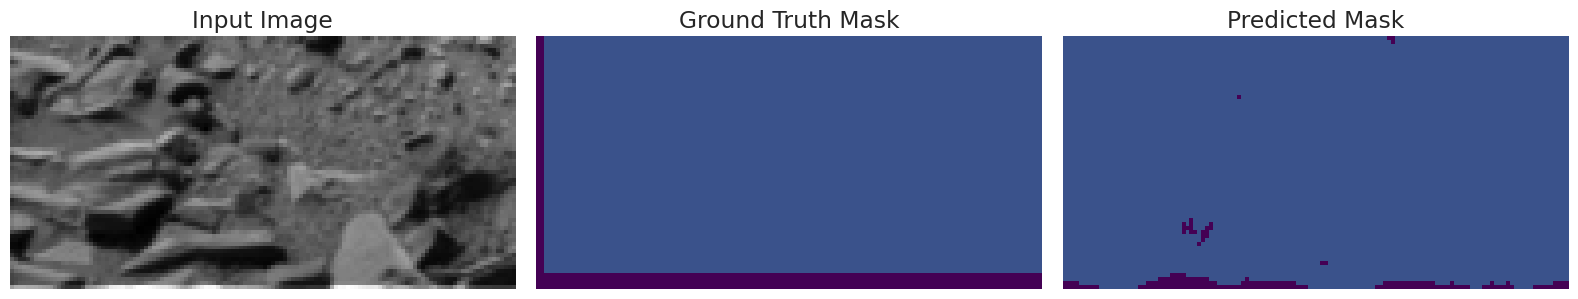

126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.8050 - class2: 0.7429 - class3: 0.8000 - class4: 0.1270 - loss: 169.3656 - mean_iou: 0.5808 - val_class1: 0.7005 - val_class2: 0.5492 - val_class3: 0.6914 - val_class4: 0.1525 - val_loss: 158.8771 - val_mean_iou: 0.4858
Epoch 87/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8122 - class2: 0.7539 - class3: 0.8116 - class4: 0.1686 - loss: 168.8082 - mean_iou: 0.6084 - val_class1: 0.7586 - val_class2: 0.6057 - val_class3: 0.7071 - val_class4: 0.1893 - val_loss: 158.6808 - val_mean_iou: 0.5410
Epoch 88/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - class1: 0.8137 - class2: 0.7568 - class3: 0.8108 - class4: 0.1718 - loss: 168.8541 - mean_iou: 0.6091 - val_class1: 0.7006 - val_class2: 0.6021 - val_class3: 0.6610 - val_class4: 9.8879e-04 - val_loss: 157.8849 - val_mean_iou: 0.4506
Epoch 89/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8168 - class2: 0.7560 - class3: 0.8160 - class4: 0.1644 - loss: 169.0477 - mea

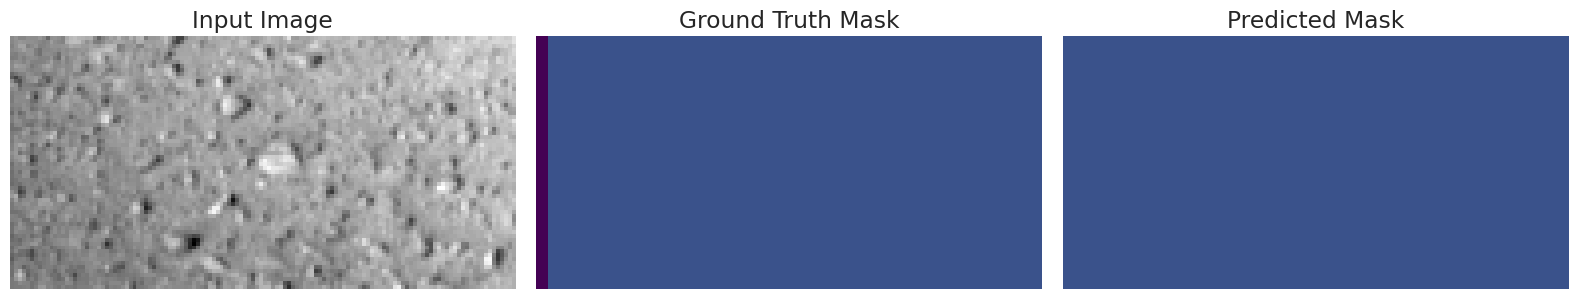

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.7800 - class2: 0.7192 - class3: 0.7789 - class4: 0.0958 - loss: 169.5105 - mean_iou: 0.5544 - val_class1: 0.7090 - val_class2: 0.6181 - val_class3: 0.6806 - val_class4: 0.1247 - val_loss: 158.4869 - val_mean_iou: 0.5047
Epoch 92/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.8188 - class2: 0.7616 - class3: 0.8205 - class4: 0.1602 - loss: 169.0019 - mean_iou: 0.6083 - val_class1: 0.7001 - val_class2: 0.5758 - val_class3: 0.7109 - val_class4: 0.2352 - val_loss: 158.1300 - val_mean_iou: 0.5238
Epoch 94/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8229 - class2: 0.7675 - class3: 0.8235 - class4: 0.1718 - loss: 168.7880 - mean_iou: 0.6143 - val_class1: 0.7175 - val_class2: 0.6150 - val_class3: 0.6426 - val_class4: 0.1709 - val_loss: 158.4062 - val_mean_iou: 0.5211
Epoch 95/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8289 - class2: 0.7713 - class3: 0.8277 - class4: 0.1897 - loss: 168.9397 - mean_io

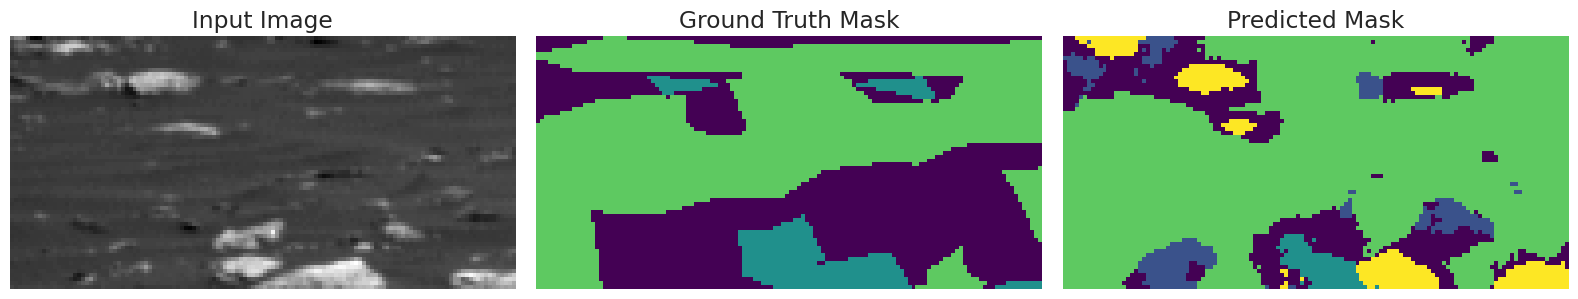

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8244 - class2: 0.7724 - class3: 0.8256 - class4: 0.1912 - loss: 169.0311 - mean_iou: 0.6231 - val_class1: 0.7399 - val_class2: 0.6173 - val_class3: 0.7023 - val_class4: 0.1767 - val_loss: 158.1699 - val_mean_iou: 0.5433
Epoch 97/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8053 - class2: 0.7488 - class3: 0.8031 - class4: 0.1457 - loss: 169.1765 - mean_iou: 0.5933 - val_class1: 0.7315 - val_class2: 0.5675 - val_class3: 0.7064 - val_class4: 0.0190 - val_loss: 158.3531 - val_mean_iou: 0.4583
Epoch 99/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8299 - class2: 0.7756 - class3: 0.8296 - class4: 0.1783 - loss: 168.9851 - mean_iou: 0.6143 - val_class1: 0.7083 - val_class2: 0.5738 - val_class3: 0.6686 - val_class4: 0.0000e+00 - val_loss: 158.8358 - val_mean_iou: 0.4410
Epoch 100/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class1: 0.8323 - class2: 0.7815 - class3: 0.8299 - class4: 0.1970 - loss: 168.4612 - mean

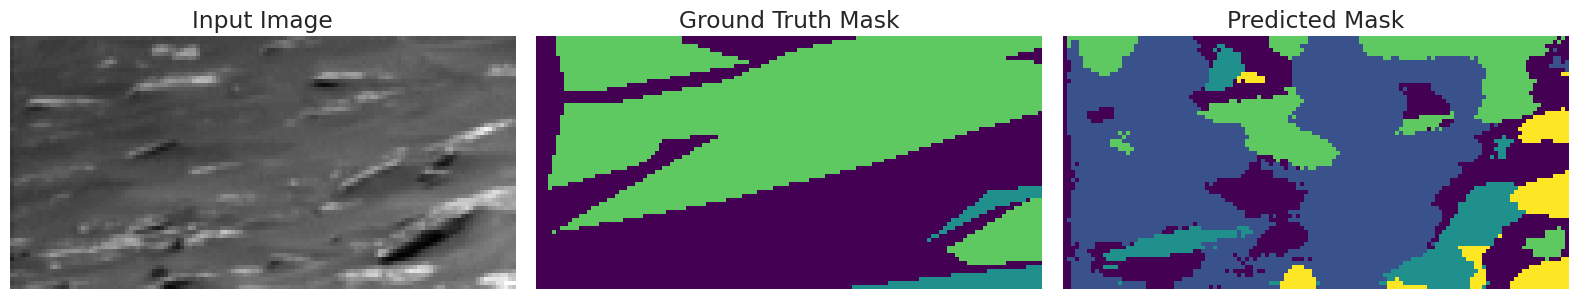

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8321 - class2: 0.7812 - class3: 0.8297 - class4: 0.1965 - loss: 168.4417 - mean_iou: 0.6283 - val_class1: 0.7160 - val_class2: 0.5376 - val_class3: 0.6101 - val_class4: 0.0147 - val_loss: 158.6212 - val_mean_iou: 0.4261
Epoch 102/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.8310 - class2: 0.7751 - class3: 0.8262 - class4: 0.1800 - loss: 168.8271 - mean_iou: 0.6145 - val_class1: 0.6919 - val_class2: 0.5559 - val_class3: 0.7028 - val_class4: 0.2010 - val_loss: 159.1115 - val_mean_iou: 0.5060
Epoch 103/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8343 - class2: 0.7818 - class3: 0.8301 - class4: 0.1987 - loss: 168.6609 - mean_iou: 0.6231 - val_class1: 0.7434 - val_class2: 0.5904 - val_class3: 0.7087 - val_class4: 0.1858 - val_loss: 159.0529 - val_mean_iou: 0.5011
Epoch 104/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8303 - class2: 0.7769 - class3: 0.8336 - class4: 0.1742 - loss: 168.6391 - mean

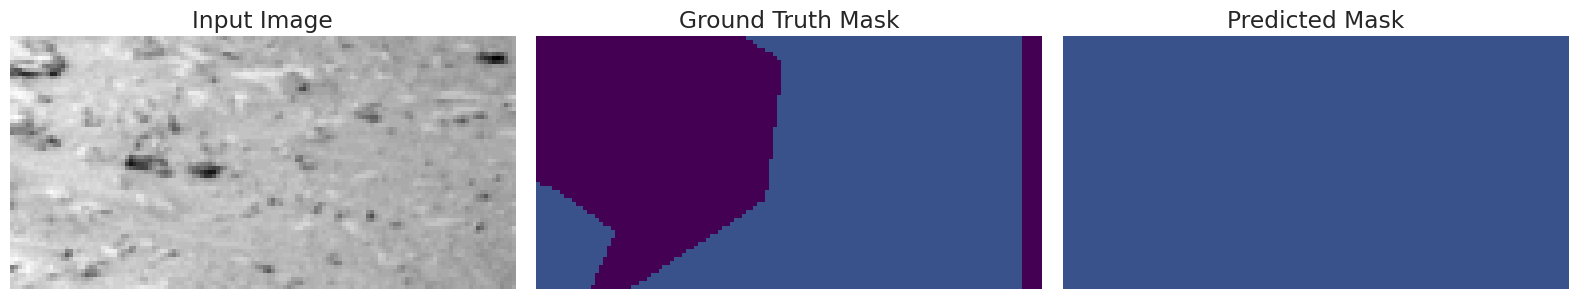

126/126 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - class1: 0.8404 - class2: 0.7872 - class3: 0.8398 - class4: 0.1974 - loss: 168.6112 - mean_iou: 0.6316 - val_class1: 0.6743 - val_class2: 0.5354 - val_class3: 0.6963 - val_class4: 3.5464e-04 - val_loss: 158.1130 - val_mean_iou: 0.4311
Epoch 107/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.8462 - class2: 0.7936 - class3: 0.8404 - class4: 0.2152 - loss: 168.8200 - mean_iou: 0.6415 - val_class1: 0.7294 - val_class2: 0.5346 - val_class3: 0.6488 - val_class4: 0.0376 - val_loss: 159.3200 - val_mean_iou: 0.4596
Epoch 110/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8461 - class2: 0.7952 - class3: 0.8432 - class4: 0.2064 - loss: 168.6752 - mean_iou: 0.6347 - val_class1: 0.7216 - val_class2: 0.5769 - val_class3: 0.7307 - val_class4: 0.2617 - val_loss: 157.9864 - val_mean_iou: 0.5394
Epoch 111/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class1: 0.8452 - class2: 0.7961 - class3: 0.8431 - class4: 0.2118 - loss: 168.9003 - me

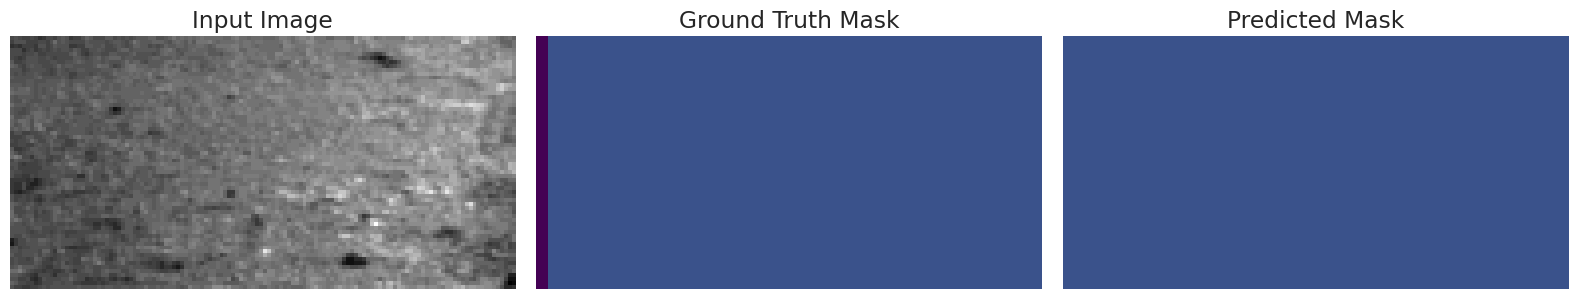

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8450 - class2: 0.7957 - class3: 0.8428 - class4: 0.2115 - loss: 168.8987 - mean_iou: 0.6374 - val_class1: 0.6930 - val_class2: 0.5914 - val_class3: 0.7062 - val_class4: 0.0341 - val_loss: 160.1329 - val_mean_iou: 0.4536
Epoch 112/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - class1: 0.8262 - class2: 0.7715 - class3: 0.8254 - class4: 0.1633 - loss: 168.9785 - mean_iou: 0.6053

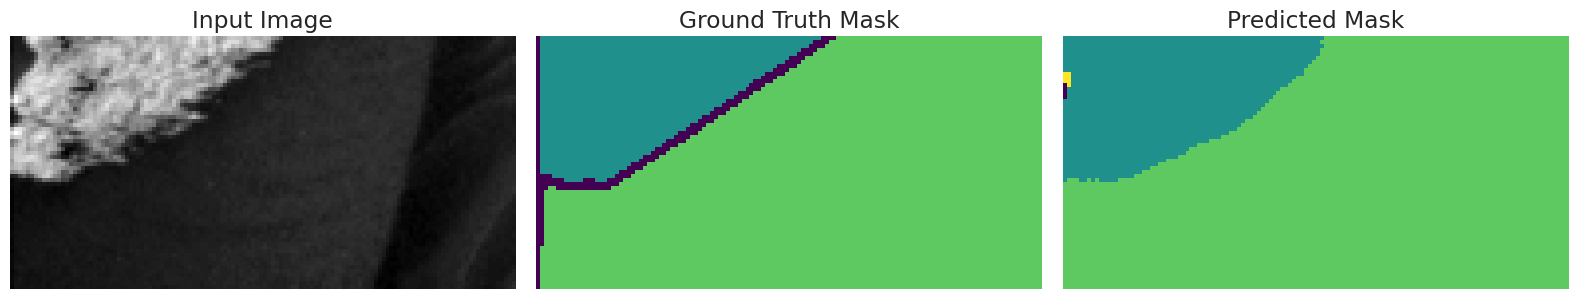

126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8259 - class2: 0.7710 - class3: 0.8250 - class4: 0.1628 - loss: 168.9732 - mean_iou: 0.6048 - val_class1: 0.7294 - val_class2: 0.5805 - val_class3: 0.7054 - val_class4: 0.2054 - val_loss: 159.6329 - val_mean_iou: 0.5329
Epoch 117/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.8462 - class2: 0.7986 - class3: 0.8478 - class4: 0.2027 - loss: 168.6660 - mean_iou: 0.6338 - val_class1: 0.7381 - val_class2: 0.5987 - val_class3: 0.7333 - val_class4: 0.2706 - val_loss: 159.5420 - val_mean_iou: 0.5533
Epoch 118/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8503 - class2: 0.8008 - class3: 0.8479 - class4: 0.1998 - loss: 168.5932 - mean_iou: 0.6339 - val_class1: 0.7427 - val_class2: 0.5742 - val_class3: 0.7142 - val_class4: 0.0659 - val_loss: 159.4820 - val_mean_iou: 0.4721
Epoch 119/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8504 - class2: 0.7992 - class3: 0.8470 - class4: 0.1948 - loss: 168.7428 - mean

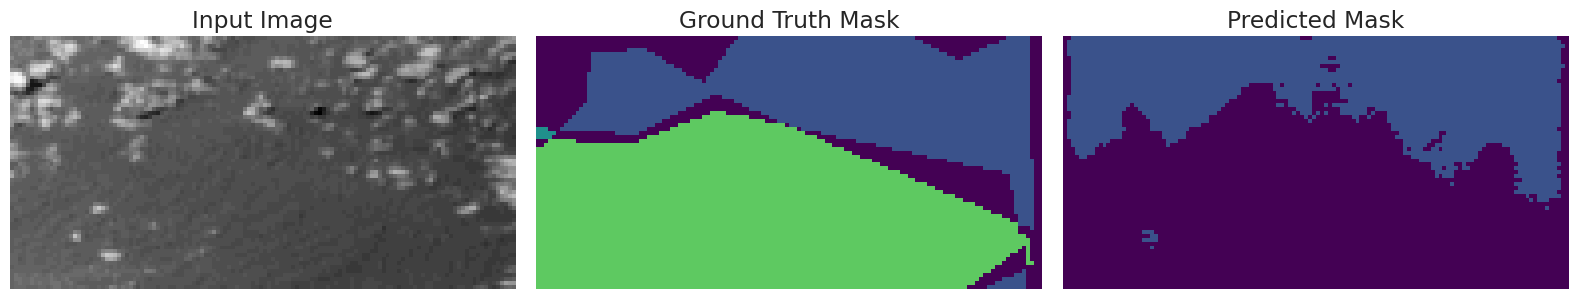

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8556 - class2: 0.8085 - class3: 0.8526 - class4: 0.2292 - loss: 168.6478 - mean_iou: 0.6457 - val_class1: 0.6739 - val_class2: 0.5268 - val_class3: 0.7146 - val_class4: 0.2087 - val_loss: 161.2052 - val_mean_iou: 0.4948
Epoch 122/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8469 - class2: 0.7984 - class3: 0.8475 - class4: 0.1862 - loss: 168.4732 - mean_iou: 0.6277 - val_class1: 0.7229 - val_class2: 0.5462 - val_class3: 0.6496 - val_class4: 0.2410 - val_loss: 160.4985 - val_mean_iou: 0.5176
Epoch 123/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8521 - class2: 0.8045 - class3: 0.8499 - class4: 0.1979 - loss: 168.4663 - mean_iou: 0.6348 - val_class1: 0.7348 - val_class2: 0.5833 - val_class3: 0.7172 - val_class4: 0.0803 - val_loss: 158.5684 - val_mean_iou: 0.4935
Epoch 124/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8580 - class2: 0.8129 - class3: 0.8545 - class4: 0.2449 - loss: 168.5843 - mean

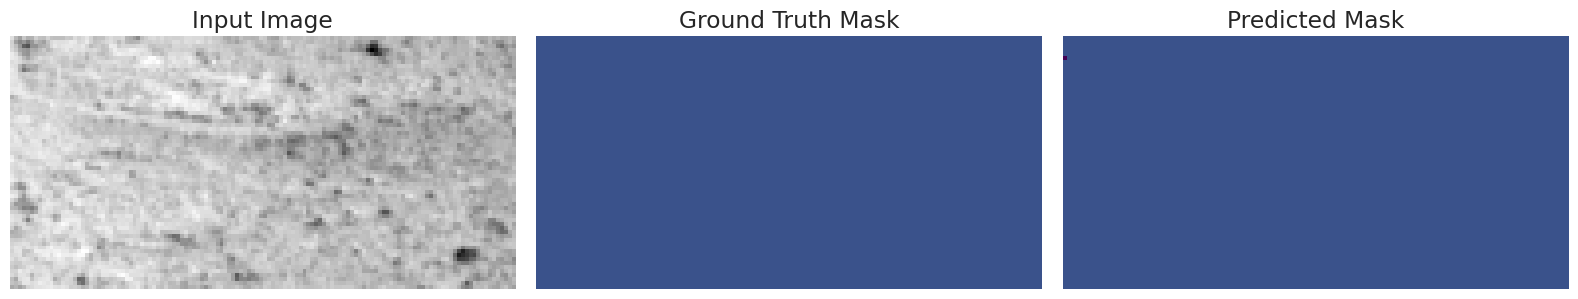

126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8604 - class2: 0.8138 - class3: 0.8588 - class4: 0.2420 - loss: 168.1237 - mean_iou: 0.6551 - val_class1: 0.7257 - val_class2: 0.5808 - val_class3: 0.6865 - val_class4: 0.2480 - val_loss: 158.0759 - val_mean_iou: 0.5302
Epoch 127/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.8612 - class2: 0.8139 - class3: 0.8562 - class4: 0.2336 - loss: 168.5647 - mean_iou: 0.6582 - val_class1: 0.7266 - val_class2: 0.5582 - val_class3: 0.7446 - val_class4: 0.2981 - val_loss: 159.9505 - val_mean_iou: 0.5374
Epoch 128/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8617 - class2: 0.8186 - class3: 0.8595 - class4: 0.2584 - loss: 168.6249 - mean_iou: 0.6668 - val_class1: 0.7455 - val_class2: 0.6042 - val_class3: 0.7417 - val_class4: 0.3182 - val_loss: 158.8598 - val_mean_iou: 0.5683
Epoch 129/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8623 - class2: 0.8157 - class3: 0.8596 - class4: 0.2635 - loss: 168.5437 - mean

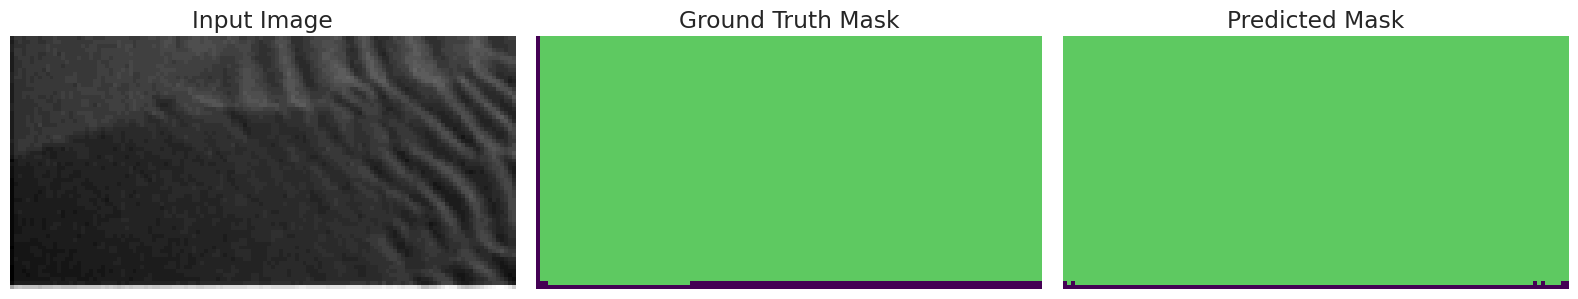

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8657 - class2: 0.8211 - class3: 0.8620 - class4: 0.2787 - loss: 168.5653 - mean_iou: 0.6735 - val_class1: 0.7717 - val_class2: 0.6035 - val_class3: 0.7392 - val_class4: 0.1647 - val_loss: 158.5089 - val_mean_iou: 0.5254
Epoch 132/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - class1: 0.8649 - class2: 0.8207 - class3: 0.8615 - class4: 0.2524 - loss: 168.4409 - mean_iou: 0.6654 - val_class1: 0.6886 - val_class2: 0.5665 - val_class3: 0.7049 - val_class4: 0.2698 - val_loss: 158.8340 - val_mean_iou: 0.5284
Epoch 133/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8624 - class2: 0.8213 - class3: 0.8629 - class4: 0.2516 - loss: 168.3910 - mean_iou: 0.6567 - val_class1: 0.7548 - val_class2: 0.5430 - val_class3: 0.7139 - val_class4: 0.2845 - val_loss: 158.5254 - val_mean_iou: 0.5371
Epoch 134/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - class1: 0.8650 - class2: 0.8227 - class3: 0.8617 - class4: 0.2608 - loss: 168.4365 - mean

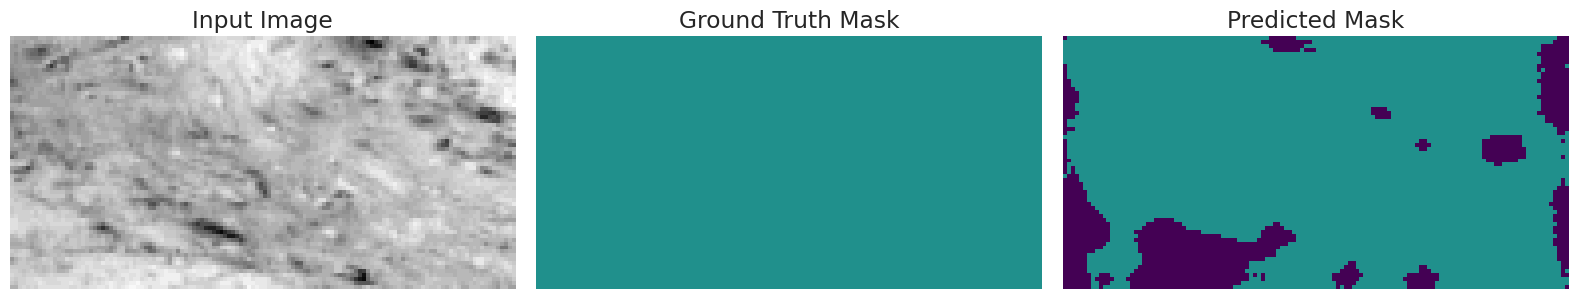

126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8686 - class2: 0.8279 - class3: 0.8674 - class4: 0.2761 - loss: 168.5040 - mean_iou: 0.6696 - val_class1: 0.7241 - val_class2: 0.5874 - val_class3: 0.7019 - val_class4: 0.0962 - val_loss: 160.0032 - val_mean_iou: 0.4870
Epoch 137/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8617 - class2: 0.8216 - class3: 0.8619 - class4: 0.2650 - loss: 168.5660 - mean_iou: 0.6662 - val_class1: 0.7121 - val_class2: 0.5912 - val_class3: 0.7260 - val_class4: 0.1166 - val_loss: 158.8602 - val_mean_iou: 0.5055
Epoch 138/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8606 - class2: 0.8123 - class3: 0.8574 - class4: 0.1998 - loss: 168.5081 - mean_iou: 0.6434 - val_class1: 0.7145 - val_class2: 0.5338 - val_class3: 0.7191 - val_class4: 0.0147 - val_loss: 157.8717 - val_mean_iou: 0.4515
Epoch 139/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - class1: 0.8317 - class2: 0.7694 - class3: 0.8267 - class4: 0.1469 - loss: 168.8544 - mean

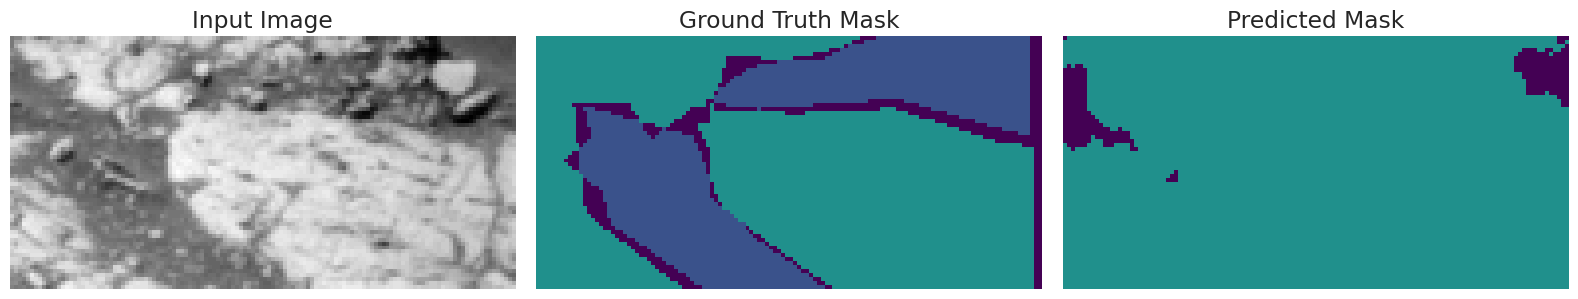

126/126 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - class1: 0.8196 - class2: 0.7548 - class3: 0.8099 - class4: 0.1467 - loss: 169.0532 - mean_iou: 0.5944 - val_class1: 0.7674 - val_class2: 0.5972 - val_class3: 0.7597 - val_class4: 0.2590 - val_loss: 158.5868 - val_mean_iou: 0.5648
Epoch 142/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - class1: 0.8611 - class2: 0.8163 - class3: 0.8596 - class4: 0.2368 - loss: 168.5894 - mean_iou: 0.6556 - val_class1: 0.7568 - val_class2: 0.5385 - val_class3: 0.6915 - val_class4: 0.3147 - val_loss: 161.4315 - val_mean_iou: 0.5332
Final validation Mean Intersection Over Union: 58.09%


In [64]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1,
        class_weight={0:1,1:1,2:1,3:1,4:100}
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

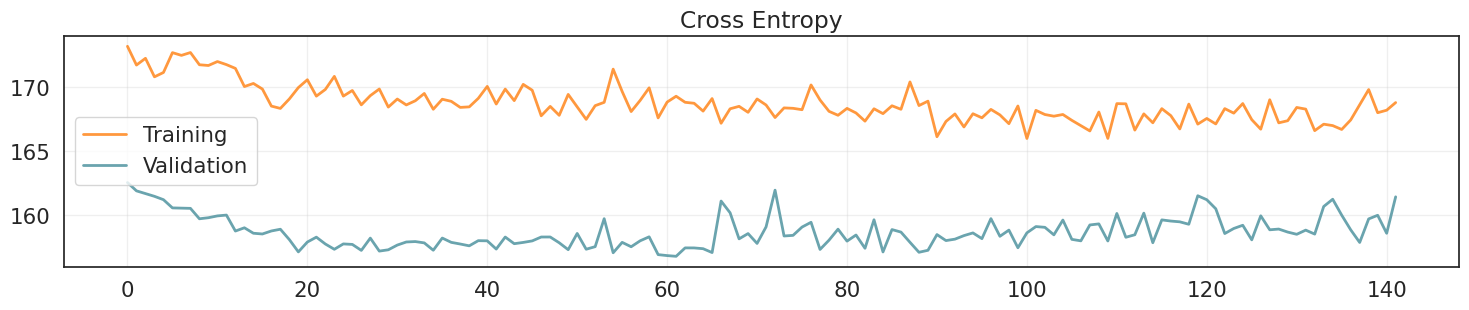

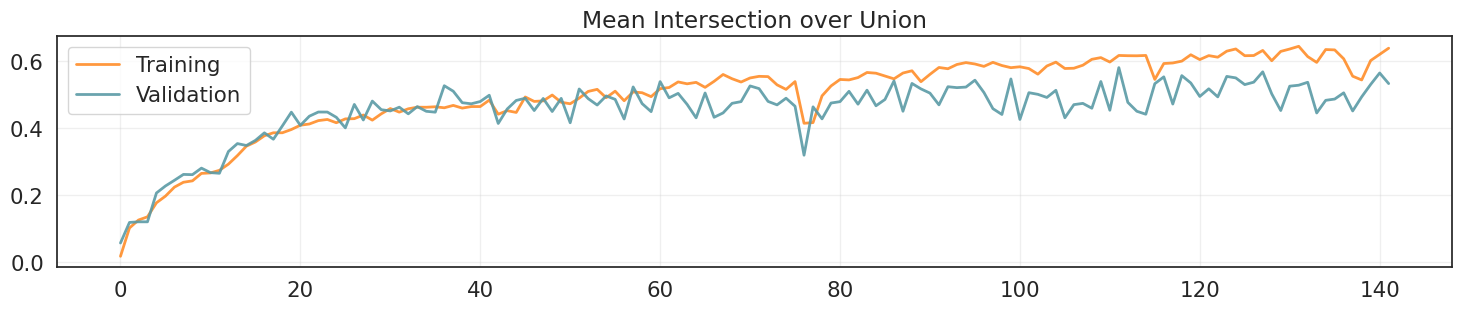

In [67]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [146]:
import tensorflow as tf
from tensorflow.keras import layers, Model


def post_processing_network(input_shape, num_classes):
    
    inputs = layers.Input(shape=input_shape)

    # Encoder (contrazione)
    x1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    # Decoder (espansione)
    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(p1)
    u1 = layers.concatenate([u1, x1], axis=3)
    u1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(u1)
    u1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(u1)

    # Output
    output = layers.Conv2D(num_classes, (1, 1), activation="softmax")(u1)

    model = Model(inputs, output)
    
    return model
    
@tf.function
def loss_post_processing(y_true, y_pred):

    iou0 = iou_loss_for_class(y_true, y_pred, 0)
    iou1 = iou_loss_for_class(y_true, y_pred, 1)
    iou2 = iou_loss_for_class(y_true, y_pred, 2)
    iou3 = iou_loss_for_class(y_true, y_pred, 3)
    iou4 = iou_loss_for_class(y_true, y_pred, 4)
    
    return iou1 + iou2 + iou3 + 500*iou4
    
with strategy.scope():
    model_post_processing = post_processing_network((64, 128, NUM_CLASSES), NUM_CLASSES)
    model_post_processing.compile(
        loss=loss_post_processing,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
            tf.keras.metrics.IoU(NUM_CLASSES, [0], name="class0", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [1], name="class1", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [2], name="class2", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [3], name="class3", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [4], name="class4", sparse_y_true=False, sparse_y_pred=False)
        ]
    )

In [84]:
model.save("/kaggle/working/transformer.keras")

In [94]:
# Funzione per creare un dataset di predizioni e label
def create_predicted_dataset(model, dataset, max_batch = 10):
    predictions = []
    labels = []

    i = 0
    for X_batch, y_batch in dataset:
        if (i > max_batch):
            break
        preds = model.predict(X_batch)  # Calcola le predizioni
        predictions.append(preds)
        labels.append(y_batch.numpy())  # Converte le etichette in NumPy per una gestione più facile
        i += 1
        
    # Concatenazione delle predizioni e delle etichette
    predictions = tf.concat(predictions, axis=0)
    labels = tf.concat(labels, axis=0)
    
    # Stampa delle forme
    print(f"Predictions shape: {predictions.shape}")
    print(f"Labels shape: {labels.shape}")

    # Creazione di un nuovo dataset (predizioni, etichette)
    new_dataset = tf.data.Dataset.from_tensor_slices((predictions, labels))

    dataset2 = new_dataset.map(
        lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset3 = new_dataset.map(
        lambda x, y: random_zoom(x, y, seed=seed),  # Define random_flip for augmentation if necessary
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset4 = new_dataset.map(
        lambda x, y: random_flip_up_down(x, y, seed=seed),  # Define random_flip for augmentation if necessary
        num_parallel_calls=tf.data.AUTOTUNE
    )
        
    dataset = new_dataset.concatenate(dataset2)
    dataset = new_dataset.concatenate(dataset3)
    dataset = new_dataset.concatenate(dataset4)


    # Batch the data
    new_dataset = new_dataset.batch(16, drop_remainder=False)
    new_dataset = new_dataset.prefetch(tf.data.AUTOTUNE)
    
    return new_dataset

# Creazione dei nuovi dataset
train_pred_dataset = create_predicted_dataset(model, train_dataset)
val_pred_dataset = create_predicted_dataset(model, val_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predictions shape: (2816, 64, 128, 5)
Labels shape: (2816, 64, 128, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predictions shape: (275, 64, 128, 5)
Labels shape: (275, 64, 128, 5)


In [79]:
print(preds_training.shape)
print(y_train.shape)

(32064, 64, 128, 5)
(8016, 64, 128)


In [142]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='mean_iou',
        mode='max',
        patience=40,
        restore_best_weights=True
    )

In [147]:
# Train the model
with strategy.scope():
    history = model_post_processing.fit(
        val_pred_dataset,
        epochs=1000,
        #validation_data=val_pred_dataset,
        callbacks=[early_stopping],
        verbose=1,
        class_weight={0:1,1:1,2:1,3:1,4:100}
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - class0: 0.0066 - class1: 0.5485 - class2: 0.2559 - class3: 0.3446 - class4: 0.0000e+00 - loss: 525.0983 - mean_iou: 0.2779
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - class0: 0.0000e+00 - class1: 0.7214 - class2: 0.5513 - class3: 0.6073 - class4: 0.0000e+00 - loss: 524.9806 - mean_iou: 0.6700
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - class0: 0.0000e+00 - class1: 0.7289 - class2: 0.5631 - class3: 0.6246 - class4: 0.0000e+00 - loss: 524.6926 - mean_iou: 0.6841
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - class0: 0.0000e+00 - class1: 0.6906 - class2: 0.5590 - class3: 0.6783 - class4: 0.0000e+00 - loss: 523.9237 - mean_iou: 0.6877
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - class0: 0.0000e+00 - class1: 0.6499 - class2: 0.5632 - class3: 0.7338 - class4: 0.0105 - loss: 522.7274 - mean_iou: 0.6869
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - class0: 0.0000e+00 - class1: 0.6411 - class

KeyboardInterrupt: 

In [66]:
import numpy as np
import tensorflow as tf

def predict_with_threshold(y_pred, num_classes, thresholds):
    """
    Predice la classe di ogni pixel nel batch di immagini, tenendo conto delle soglie per ogni classe.

    Parameters:
        model (tf.keras.Model): Modello TensorFlow per fare le predizioni.
        x (np.array): Immagini di input (shape: batch_size, height, width, channels).
        num_classes (int): Numero di classi.
        thresholds (list): Lista di soglie per ogni classe.

    Returns:
        np.array: Maschera di predizione (shape: batch_size, height, width) con la classe predetta per ogni pixel.
    """
    batch_size, height, width, _ = y_pred.shape
    predicted_mask = np.zeros((batch_size, height, width), dtype=int)

    # Iteriamo sui pixel
    for b in range(batch_size):
        for i in range(height):
            for j in range(width):
                # Otteniamo le probabilità per tutte le classi per il pixel (i, j)
                probabilities = y_pred[b, i, j]
                
                # Ordiniamo le probabilità in ordine decrescente e otteniamo gli indici delle classi
                '''sorted_classes = np.argsort(probabilities)[::-1]  # Classi ordinate in base alla probabilità (decrescente)
                
                # Per ogni classe, verifica se la probabilità supera la soglia
                assigned_class = 0  # Classe di default (classe 0)
                for class_idx in sorted_classes:
                    if probabilities[class_idx] >= thresholds[class_idx]:
                        assigned_class = class_idx
                        break'''
                
                # Assegna il pixel alla classe trovata
                #predicted_mask[b, i, j] = assigned_class

    return predicted_mask


def calculate_miou_from_model_with_threshold(model, val_dataset, num_classes, thresholds):
    """
    Calcola la Mean Intersection over Union (mIoU) utilizzando una soglia specifica per ogni classe.

    Parameters:
        model (tf.keras.Model): Modello TensorFlow per fare le predizioni.
        val_dataset (tf.data.Dataset): Dataset di validazione (x, y), dove y è one-hot encoded.
        num_classes (int): Numero di classi.
        thresholds (list): Soglie per ogni classe.

    Returns:
        float: MIoU calcolata sulle classi.
    """
    intersection_sum = np.zeros(num_classes)
    union_sum = np.zeros(num_classes)

    y_pred = model.predict(val_dataset)  # y_pred shape (batch_size, height, width, num_classes)
    y_true = y_val

    y_pred_mask = predict_with_threshold(y_pred, num_classes, thresholds)  # Predizioni con soglie

    # Confrontiamo la predizione con la verità di terra
    for c in range(num_classes):
        pred_mask = (y_pred_mask == c)
        true_mask = (y_true == c)  # Verità di terra per la classe c

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        intersection_sum[c] += intersection
        union_sum[c] += union

    # Calcola la IoU per ogni classe
    iou_per_class = [
        intersection_sum[c] / union_sum[c] if union_sum[c] != 0 else 1.0
        for c in range(num_classes)
    ]

    # Media delle IoU per tutte le classi
    miou = np.mean(iou_per_class)
    return miou


def find_optimal_threshold_for_class(model, val_dataset, num_classes, thresholds=np.arange(0.0, 0.9, 0.2)):
    """
    Trova la soglia ottimale per ogni classe che massimizza la Mean IoU (mIoU).

    Parameters:
        model (tf.keras.Model): Modello TensorFlow per fare le predizioni.
        val_dataset (tf.data.Dataset): Dataset di validazione (x, y), dove y è one-hot encoded.
        num_classes (int): Numero di classi.
        thresholds (array): Intervallo di soglie da testare.

    Returns:
        list: Una lista con la soglia ottimale per ciascuna classe.
    """
    optimal_thresholds = []

    # Per ciascuna classe, testiamo diverse soglie
    for class_idx in range(num_classes):
        class_idx=0
        best_miou = -1
        best_threshold = 0.0
        
        for threshold in thresholds:
            # Calcola la mIoU con la soglia corrente
            miou = calculate_miou_from_model_with_threshold(
                model, val_dataset, num_classes, thresholds=[threshold if i == class_idx else 0.0 for i in range(num_classes)])
            
            # Aggiorna la soglia se la mIoU è migliore
            if miou > best_miou:
                best_miou = miou
                best_threshold = threshold
    
                print(best_miou)
    
        # Salviamo la soglia ottimale per questa classe
        optimal_thresholds.append(best_threshold)

    return optimal_thresholds


# Esempio di utilizzo:
optimal_thresholds = find_optimal_threshold_for_class(model, val_dataset, NUM_CLASSES)

# Mostra la soglia ottimale per ogni classe
for i, threshold in enumerate(optimal_thresholds):
    print(f"Soglia ottimale per la classe {i}: {threshold:.2f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
0.049165974691242516
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
0.049165974691242516
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
0.049165974691242516
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
0.049165974691242516
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
0.049165974691242516
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
21/21 ━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
model.save("/kaggle/working/keras.h5")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.
    
    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []
    
    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_dataset, [0,1,2,3,4])

In [68]:
model.evaluate(val_dataset)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - class1: 0.7117 - class2: 0.5795 - class3: 0.7381 - class4: 0.1002 - loss: nan - mean_iou: 0.4955   


[159.45480346679688,
 0.5625826120376587,
 0.7098696827888489,
 0.6259270906448364,
 0.6774324774742126,
 0.3128204941749573]

In [ ]:
X_val_pred = np.expand_dims(X_val, axis=3)

preds = model.predict(X_val_pred)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
background = 0
threshold_percentage = 70

# Itera su tutte le immagini e maschere
for i in range(len(preds)):
    
    if np.any(preds[i] == background):

        total_pixels = 64 * 128
        label_pixels = np.sum(preds[i] == background)
        label_percentage = (label_pixels / total_pixels) * 100

        #if ((label_percentage <= threshold_percentage)):
        new_label = cleaning_background(preds[i])
        preds[i] = new_label


In [ ]:
y_true = []
y_pred = []


for i in range(len(preds)):
    y_true.extend(y_val[i])
    y_pred.extend(preds[i])

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [69]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step
Predictions shape: (10022, 64, 128)


In [135]:
preds = model.predict(X_test)
preds2 = model_post_processing.predict(preds)

314/314 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [136]:
preds = np.argmax(preds2, axis=-1)
print(f"Predictions shape: {preds.shape}")

Predictions shape: (10022, 64, 128)


In [ ]:
background = 0
threshold_percentage = 60

# Itera su tutte le immagini e maschere
for i in range(len(preds)):
    
    if np.any(preds[i] == background):

        total_pixels = 64 * 128
        label_pixels = np.sum(preds[i] == background)
        label_percentage = (label_pixels / total_pixels) * 100
            
        #if ((label_percentage <= threshold_percentage)):
        new_label = cleaning_background(preds[i])
        preds[i] = new_label

In [70]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [137]:
from time import time

# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)